In [1]:
#초기 설정및 시스템 라이브러리
import platform
import warnings

# 데이터 시각화 라이브러리
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
print(platform.system())
warnings.filterwarnings('ignore')

# 통계 라이브러리
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, kruskal
import statsmodels.api as sm

# 행,열,결과값 생략 없이 보기,세팅
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

# 한글 폰트 설정
pd.set_option("display.float_format","{:.2f}".format)
# OS에 따라 다른 폰트 지정
if platform.system() == 'Darwin':   # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':  # Windows
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux (예: Colab, Ubuntu)
    plt.rcParams['font.family'] = 'NanumGothic'

Darwin


# 데이터 불러오기 : successed_founder_company.csv

In [2]:
# peo = pd.read_csv("./data/clean_data/clean_people_final.csv")
rel = pd.read_csv("./data/clean_data/clean_relationships_final.csv")
# obj = pd.read_csv("./data/clean_data/clean_objects_final.csv")
# frs = pd.read_csv("./data/clean_data/clean_fr_final.csv")
# fds = pd.read_csv("./data/clean_data/clean_funds_final.csv")
# off = pd.read_csv("./data/clean_data/clean_offices_final.csv")
# ipo = pd.read_csv("./data/clean_data/clean_ipos_final.csv")
# acq = pd.read_csv("./data/clean_data/clean_acquisitions_final.csv")
# deg = pd.read_csv("./data/clean_data/clean_degrees_final.csv")
mil = pd.read_csv("./data/clean_data/clean_milestones_final.csv")
# inv = pd.read_csv("./data/clean_data/clean_investments_final.csv")

In [3]:
df = pd.read_csv('./data/successed_founder_company.csv', low_memory=False)

# 가설7 사용 위해
mil = pd.read_csv('./data/clean_data/clean_milestones_final.csv', low_memory=False)

In [4]:
print(df.shape, mil.shape)
print(df.columns.tolist())
print(mil.columns.tolist())

(59516, 17) (39456, 5)
['rel_p_id', 'founder_ever_success', 'rel_cf_id', 'n_founding', 'is_past', 'sequence', 'birthplace', 'degree_level', 'subject', 'institution', 'graduated_at', 'objects_cfpr_id', 'success_flag_x', 'success_flag_y', 'relationships', 'category', 'company_size']
['Unnamed: 0', 'mile_cfpr_id', 'milestone_at', 'description', 'cat_mile_description']


In [5]:
# success_flag_x, success_flag_y 하나 삭제 -> 열이름 변경
df.drop('success_flag_y', axis=1, inplace=True)
df.rename(columns={'success_flag_x': 'success_flag'}, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59516 entries, 0 to 59515
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   rel_p_id              59516 non-null  object 
 1   founder_ever_success  59516 non-null  int64  
 2   rel_cf_id             59516 non-null  object 
 3   n_founding            59516 non-null  int64  
 4   is_past               59516 non-null  int64  
 5   sequence              59516 non-null  int64  
 6   birthplace            9986 non-null   object 
 7   degree_level          21167 non-null  float64
 8   subject               18426 non-null  object 
 9   institution           22474 non-null  object 
 10  graduated_at          15718 non-null  object 
 11  objects_cfpr_id       59212 non-null  object 
 12  success_flag          59212 non-null  float64
 13  relationships         59212 non-null  float64
 14  category              58905 non-null  object 
 15  company_size       

In [7]:
# ===================================
# 타겟 정리
# success_flag: 0/1 
# ===================================
df['success_flag'] = pd.to_numeric(df['success_flag'], errors='coerce')
df = df.dropna(subset=['success_flag']).copy()
df['success_flag'] = df['success_flag'].astype(int)

df['success_flag'].value_counts(dropna=False)

success_flag
0    52814
1     6398
Name: count, dtype: int64

# 반복 실행용 : 정규성 / 등분산성 / 효과크기 / 검정 선택

1) 정규성 체크

In [8]:
def check_normality(x, alpha=0.05):
    """
    n<=5000: Shapiro-Wilk
    n>5000 : D’Agostino K^2
    H0: 정규분포
    """
    x = pd.Series(x).dropna().astype(float)
    n = len(x)
    if n < 8:
        return {"n": n, "test": None, "p": np.nan, "normal": None}
    if n <= 5000:
        stat, p = stats.shapiro(x)
        return {"n": n, "test": "Shapiro", "p": p, "normal": (p >= alpha)}
    stat, p = stats.normaltest(x)
    return {"n": n, "test": "Normaltest(K2)", "p": p, "normal": (p >= alpha)}

2) 등분산 체크

In [9]:
def check_equal_var(a, b, alpha=0.05):
    a = pd.Series(a).dropna().astype(float)
    b = pd.Series(b).dropna().astype(float)
    stat, p = stats.levene(a, b, center='median')
    return {"test": "Levene(median)", "p": p, 'equal_var': (p >= alpha)}

3) 효과크기

    - 연속형 2그룹 : cohens's / hedges g
    - 비모수 2그룹 : cliff's delta
    - 범주형(카이제곱): cramer's v
    - 로지스틱 : odds ratid(=exp(beta))가 효과크기 역할

In [10]:
def cohens_d(a, b):
    a = pd.Series(a).dropna().astype(float)
    b = pd.Series(b).dropna().astype(float)
    n1, n2 = len(a), len(b)
    s1, s2 = a.std(ddof=1), b.std(ddof=1)
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    return (a.mean() - b.mean()) / sp

def hedges_g(a, b):
    d = cohens_d(a, b)
    a = pd.Series(a).dropna()
    b = pd.Series(b).dropna()
    n1, n2 = len(a), len(b)
    J = 1 - (3 / (4*(n1+n2) - 9))
    return J * d

def cliffs_delta(a, b):
    a = pd.Series(a).dropna().astype(float).values
    b = pd.Series(b).dropna().astype(float).values
    m, n = len(a), len(b)
    gt = sum(ai > bj for ai in a for bj in b)
    lt = sum(ai < bj for ai in a for bj in b)
    return (gt - lt) / (m*n)

def cramers_v(ct):
    chi2, p, dof, exp = chi2_contingency(ct)
    n = ct.to_numpy().sum()
    r, k = ct.shape
    return np.sqrt((chi2 / n) / (min(r-1, k-1)))

4) 연속형 vs 이진 성공 : 자동 검정 선택 함수

    - 정규성 & 등분산 만족 -> t-test / welch
    - 아니면 -> mann-whitney u
    - 유의할 때만 효과크기 계산

In [11]:
def test_continuous_vs_binary(df, x, y="success_flag", alpha=0.05, do_checks=True):
    """
    x(연속/서열) vs y(이진)
    - (옵션) 정규성/등분산 확인 후 t-test/Welch or Mann-Whitney
    - 유의하면 effect size 계산
    """
    tmp = df[[x, y]].dropna().copy()
    g0 = tmp[tmp[y]==0][x]
    g1 = tmp[tmp[y]==1][x]

    result = {"x": x, "n0": len(g0), "n1": len(g1)}

    if do_checks:
        n0 = check_normality(g0, alpha=alpha)
        n1 = check_normality(g1, alpha=alpha)
        ev = check_equal_var(g0, g1, alpha=alpha)
        result.update({"normal0": n0, "normal1": n1, "equal_var": ev})

        normal_ok = (n0["normal"] is True) and (n1["normal"] is True)
        equal_ok  = (ev["equal_var"] is True)
    else:
        normal_ok, equal_ok = False, False

    # 검정 선택
    if do_checks and normal_ok:
        if equal_ok:
            stat, p = stats.ttest_ind(g0, g1, equal_var=True, nan_policy="omit")
            test_name = "Student t-test"
        else:
            stat, p = stats.ttest_ind(g0, g1, equal_var=False, nan_policy="omit")
            test_name = "Welch t-test"
    else:
        stat, p = mannwhitneyu(g0, g1, alternative="two-sided")
        test_name = "Mann–Whitney U"

    result.update({"test": test_name, "stat": stat, "p": p})

    # 유의할 때만 효과크기
    if p < alpha:
        if test_name in ["Student t-test", "Welch t-test"]:
            result["effect"] = {"cohens_d": cohens_d(g1, g0), "hedges_g": hedges_g(g1, g0)}
        else:
            result["effect"] = {"cliffs_delta": cliffs_delta(g1, g0)}
    else:
        result["effect"] = None

    return result

5) 범주형 vs 이진 성공 : 카이제곱 + 효과크기

    - h0 : 범주와 성공은 독립
    - h1 : 독립 아님
    - 유의하면 Cramer's V


In [12]:
def test_categorical_vs_binary(df, cat, y="success_flag", alpha=0.05, min_n=30):
    """
    cat(범주형) vs y(이진)
    - 희귀범주 많으면 불안정 -> 빈도 min_n 미만은 'Other'로 묶음
    - 카이제곱 + (유의시) Cramer's V
    """
    tmp = df[[cat, y]].dropna().copy()

    vc = tmp[cat].value_counts()
    keep = vc[vc >= min_n].index
    tmp[cat] = tmp[cat].where(tmp[cat].isin(keep), "Other")

    ct = pd.crosstab(tmp[cat], tmp[y])
    chi2, p, dof, exp = chi2_contingency(ct)

    result = {"cat": cat, "test": "Chi-square independence", "p": p, "chi2": chi2, "dof": dof, "table": ct}

    if p < alpha:
        result["effect"] = {"cramers_v": cramers_v(ct)}
    else:
        result["effect"] = None

    return result

# 가설별 "검정 선택/이유/h0/h1 정리 + 실행

In [13]:
df.columns

Index(['rel_p_id', 'founder_ever_success', 'rel_cf_id', 'n_founding',
       'is_past', 'sequence', 'birthplace', 'degree_level', 'subject',
       'institution', 'graduated_at', 'objects_cfpr_id', 'success_flag',
       'relationships', 'category', 'company_size'],
      dtype='object')

In [14]:
pd.options.display.float_format = '{:.3f}'.format

### 가설1) 출생지 - 성공률
 
   - 검정 : 카이제곱 독립성 검정
   - 이유 : 출생지는 범주형, 성공은 이진 -> 범주-범주 독립성 검정이 적합

        - H0 : 출생지와 성공은 독립
        - H1 : 독립이 아님(연관 있음)

        - 효과크기 : 유의 시 Cramer's V

In [15]:
bplace_result = test_categorical_vs_binary(df, cat='birthplace', min_n=30)
print(bplace_result['test'], bplace_result['p'], bplace_result['effect'])

Chi-square independence 0.1694941208033172 None


분석 대상 회사 수: 9955
출생지 카테고리 수(Other 포함): 11
success 분포:
 success_flag
0    9057
1     898
Name: count, dtype: int64


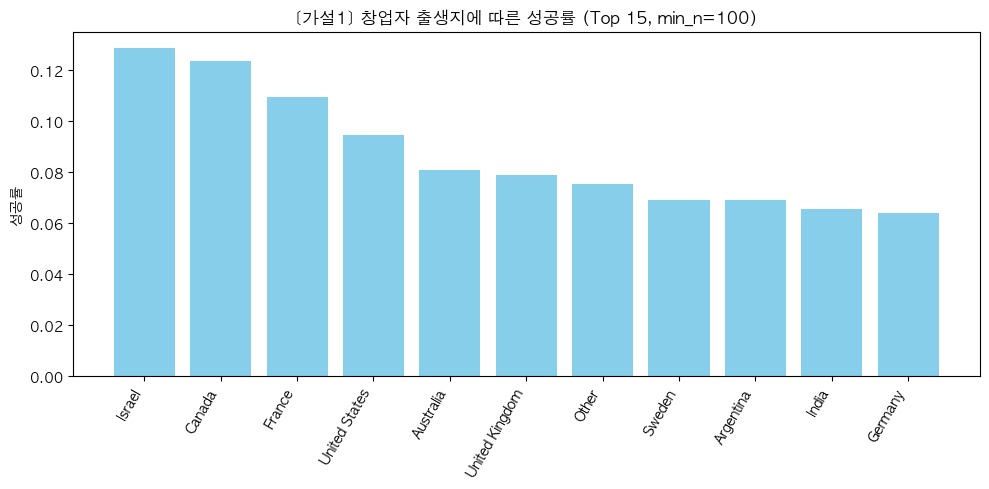

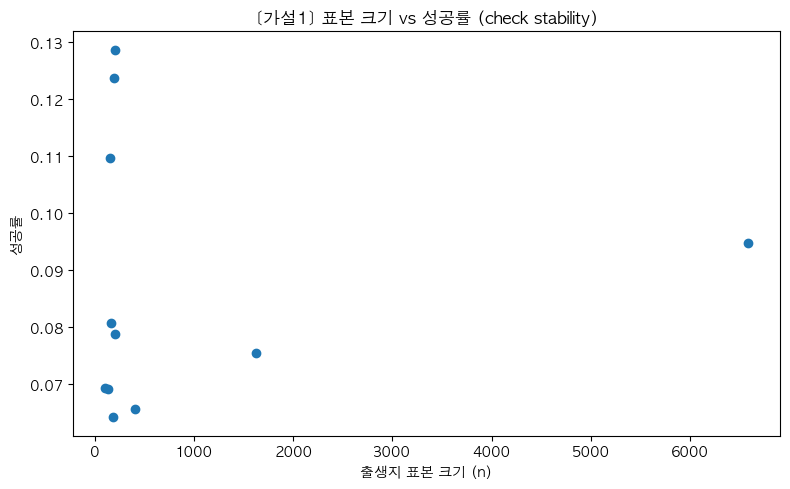


[가설1] Chi-square independence test
chi2: 19.24835164843566 | dof: 10 | p-value: 0.037219297182066166
Effect size (Cramer's V): 0.04397199196296348

[유의] 성공(1) 기준 표준화 잔차 TOP + (성공이 기대보다 많음)
birth_group
Israel            1.822
Canada            1.554
United States     1.238
France            0.807
Australia        -0.400
United Kingdom   -0.540
Sweden           -0.699
Argentina        -0.796
Germany          -1.185
India            -1.655
Name: 1, dtype: float64

[유의] 성공(1) 기준 표준화 잔차 TOP - (성공이 기대보다 적음)
birth_group
Other            -1.969
India            -1.655
Germany          -1.185
Argentina        -0.796
Sweden           -0.699
United Kingdom   -0.540
Australia        -0.400
France            0.807
United States     1.238
Canada            1.554
Name: 1, dtype: float64

🧾 [가설 1 결과 해석]
- p=0.03722 < 0.05 이므로 [출생지와 성공률은 통계적으로 유의하게 연관]이 있습니다.
- Cramer's V=0.044 → 효과크기는 작음(실무 영향은 제한적일 수 있음)

🚀 [후속 방향성 제안]
1) '어느 출생지 그룹이 차이를 만드는지' 표준화 잔차 TOP(+) / TOP(-) 중심으로 스토리 구성
2) 희귀 범주를 더 안정적으로 묶기:

In [16]:
# =========================
# 가설 1 설정
# =========================
birth_col = "birthplace"   
target = "success_flag"
alpha = 0.05        # 유의수준
min_n = 100          # 희귀 범주 묶는 기준 -> 데이터 규모에 맞게 20~100 사이로 조정
top_k_plot = 15     # 시각화에 표시할 상위 카테고리 수

# -------------------------
# 0) 안전 전처리
# -------------------------
tmp_bplace = df[[birth_col, target]].copy()
tmp_bplace[birth_col] = tmp_bplace[birth_col].replace(["nan", "None", "NULL", ""], np.nan)
tmp_bplace = tmp_bplace.dropna(subset=[birth_col, target]).copy()

# 희귀 범주를 Other로 묶어 검정 안정화
vc_bplace = tmp_bplace[birth_col].value_counts()
keep_bplace = vc_bplace[vc_bplace >= min_n].index
tmp_bplace["birth_group"] = tmp_bplace[birth_col].where(tmp_bplace[birth_col].isin(keep_bplace), "Other")

print("분석 대상 회사 수:", len(tmp_bplace))
print("출생지 카테고리 수(Other 포함):", tmp_bplace["birth_group"].nunique())
print("success 분포:\n", tmp_bplace[target].value_counts())

# =========================
# 1) 시각화 1: 출생지별 성공률(Top-K) 막대그래프
# =========================
g_bplace = (
    tmp_bplace.groupby("birth_group")[target]
       .agg(success_rate="mean", n="count")
       .reset_index()
)

# 표본 수가 충분한 그룹만 성공률 기준으로 정렬
g_plot_bplace = g_bplace.sort_values(["success_rate", "n"], ascending=[False, False]).head(top_k_plot)

plt.figure(figsize=(10, 5))
plt.bar(g_plot_bplace["birth_group"].astype(str), g_plot_bplace["success_rate"], color='skyblue')
plt.xticks(rotation=60, ha="right")
plt.ylabel("성공률")
plt.title(f"[가설1] 창업자 출생지에 따른 성공률 (Top {top_k_plot}, min_n={min_n})")
plt.tight_layout()
plt.show()

# =========================
# 2) 시각화 2: 표본 수 vs 성공률 산점도(신뢰도 확인용)
#  - 표본 수가 작은 곳은 성공률이 튀기 쉬움 → 해석 시 경계 (예: 해당 출생지가 1명인데 성공한 경우)
# =========================
plt.figure(figsize=(8, 5))
plt.scatter(g_bplace["n"], g_bplace["success_rate"])
plt.xlabel("출생지 표본 크기 (n)")
plt.ylabel("성공률")
plt.title("[가설1] 표본 크기 vs 성공률 (check stability)")
plt.tight_layout()
plt.show()

# =========================
# 3) 카이제곱 독립성 검정
#  H0: 출생지와 성공은 독립이다.
#  H1: 독립이 아니다(연관이 있다).
# =========================
ct_bplace = pd.crosstab(tmp_bplace["birth_group"], tmp_bplace[target])

chi2, p, dof, expected = chi2_contingency(ct_bplace)

# 효과크기: Cramer's V
n = ct_bplace.to_numpy().sum()
r, k = ct_bplace.shape
cramers_v = np.sqrt((chi2 / n) / (min(r-1, k-1)))

print("\n=========================")
print("[가설1] Chi-square independence test")
print("chi2:", chi2, "| dof:", dof, "| p-value:", p)
print("Effect size (Cramer's V):", cramers_v)
print("=========================\n")

# =========================
# 4) (유의할 때만) 어느 출생지가 차이를 주도하는지: 표준화 잔차
#  - 표준화 잔차 |z| > 2 정도면 기대값 대비 관측이 많이 다름(기여도 큼)
# =========================
if p < alpha:
    observed = ct_bplace.values
    std_resid = (observed - expected) / np.sqrt(expected)

    resid_df = pd.DataFrame(std_resid, index=ct_bplace.index, columns=ct_bplace.columns)

    # "성공(1)" 컬럼이 있는 경우, 성공에 대해 양(+)으로 크게 벗어난 출생지 찾기
    if 1 in resid_df.columns:
        top_pos = resid_df[1].sort_values(ascending=False).head(10)
        top_neg = resid_df[1].sort_values(ascending=True).head(10)

        print("[유의] 성공(1) 기준 표준화 잔차 TOP + (성공이 기대보다 많음)")
        print(top_pos)

        print("\n[유의] 성공(1) 기준 표준화 잔차 TOP - (성공이 기대보다 적음)")
        print(top_neg)
    else:
        print("⚠️ success_flag=1 컬럼이 교차표에 없어서 잔차 해석을 생략합니다.")

# =========================
# 5) 조건문 기반 결과 해석 + 다음 방향성(자동 출력)
# =========================
print("\n🧾 [가설 1 결과 해석]")
if p < alpha:
    # 효과크기 rough rule (상황에 따라 조정 가능)
    if cramers_v < 0.1:
        eff_txt = "효과크기는 작음(실무 영향은 제한적일 수 있음)"
    elif cramers_v < 0.3:
        eff_txt = "효과크기는 중간 이하(일부 의사결정 신호로 고려 가능)"
    else:
        eff_txt = "효과크기는 중간 이상(포트폴리오 구성/소싱 전략에 의미 있을 가능성)"

    print(f"- p={p:.4g} < {alpha} 이므로 [출생지와 성공률은 통계적으로 유의하게 연관]이 있습니다.")
    print(f"- Cramer's V={cramers_v:.3f} → {eff_txt}")

    print("\n🚀 [후속 방향성 제안]")
    print("1) '어느 출생지 그룹이 차이를 만드는지' 표준화 잔차 TOP(+) / TOP(-) 중심으로 스토리 구성")
    print("2) 희귀 범주를 더 안정적으로 묶기: 국가 단위/대도시 여부(Seoul, SF 등)로 재분류 후 재검정")
    print("3) 인과로 단정하지 말기: 다음 단계로 size_bin, total_invested, 카테고리 등을 통제한 로지스틱 회귀로 '독립 효과' 확인")
    print("4) 결과 활용(VC 관점): 특정 지역/국가 생태계에서 exit가 더 자주 나타나면, 소싱 채널/네트워크를 그쪽에 더 집중하는 전략 검토")
else:
    print(f"- p={p:.4g} ≥ {alpha} 이므로 **출생지와 성공률의 유의한 연관을 확인하지 못했습니다**(H0 기각 불가).")
    print(f"- Cramer's V={cramers_v:.3f} → (유의하지 않으므로 효과크기 해석은 보수적으로)")

    print("\n🚀 [후속 방향성 제안]")
    print("1) 범주가 너무 세분화되어 검정력이 떨어졌을 수 있음 → 국가/대륙/대도시 여부로 재분류 후 재검정")
    print("2) 표본 수 부족 그룹(min_n) 기준을 올려 '신뢰도 높은 그룹'만으로 재검정(예: min_n=50~100)")
    print("3) 출생지보다 더 강한 요인(산업 카테고리, 투자규모, 조직 안정성 등)이 있을 수 있음 → 다변량 모델로 비교")

In [17]:
g_plot_bplace
g_bplace

,birth_group,success_rate,n
0,Argentina,0.069,130
1,Australia,0.081,161
2,Canada,0.124,194
3,France,0.110,155
4,Germany,0.064,187
5,India,0.066,411
6,Israel,0.129,202
7,Other,0.076,1628
8,Sweden,0.069,101
9,United Kingdom,0.079,203


### 가설2) 출신학교 - 성공률

   - 검정 : 카이제곱
   - 이유 : 학교(범주) vs 성공(이진)

        - H0/H1 : 출신학교와 성공은 독립/연관 있음

        - 효과크기 : Cramer's V

분석 대상 회사 수: 22418
학교 카테고리 수(Other 포함): 35
success 분포:
 success_flag
0    19350
1     3068
Name: count, dtype: int64


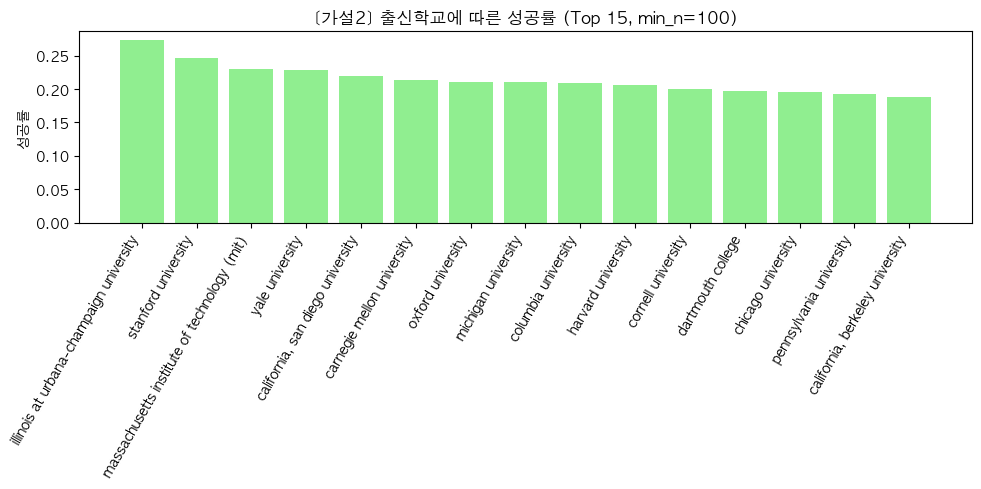

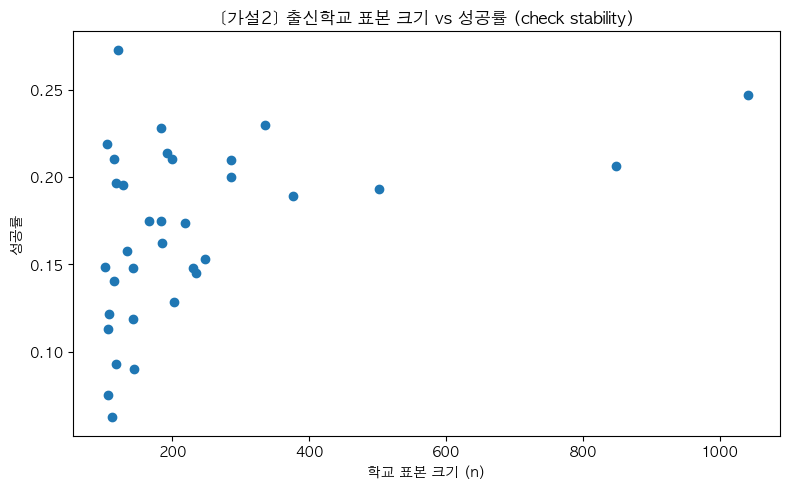


[가설2] Chi-square independence test
chi2: 391.9960626015026 | dof: 34 | p-value: 1.8677398084216627e-62
Effect size (Cramer's V): 0.1322337822024579

[유의] 성공(1) 기준 표준화 잔차 TOP + (성공이 기대보다 많음)
school_group
stanford university                           9.596
harvard university                            5.472
massachusetts institute of technology (mit)   4.601
illinois at urbana-champaign university       4.040
pennsylvania university                       3.414
yale university                               3.352
columbia university                           3.334
cornell university                            2.882
carnegie mellon university                    2.872
michigan university                           2.796
Name: 1, dtype: float64

[유의] 성공(1) 기준 표준화 잔차 TOP - (성공이 기대보다 적음)
school_group
Other                         -8.746
technology university         -2.127
california state university   -1.708
university                    -1.511
insead                        -1.281
arizona stat

In [18]:
# =========================
# 가설 2 설정
# =========================
institution_col = "institution"   # 출신 학교
target = "success_flag"
alpha = 0.05
min_n = 100                  # 희귀 학교를 Other로 묶는 기준 -> 데이터 크면 50~100
top_k_plot = 15              # 시각화에 표시할 상위 학교 수

# -------------------------
# 0) 안전 전처리
# -------------------------
tmp_inst = df[[institution_col, target]].copy()
tmp_inst[institution_col] = tmp_inst[institution_col].replace(["nan", "None", "NULL", ""], np.nan)
tmp_inst = tmp_inst.dropna(subset=[institution_col, target]).copy()

# 희귀 학교는 Other로 묶기 (검정 안정화 + 시각화 가독성)
vc_inst = tmp_inst[institution_col].value_counts()
keep_inst = vc_inst[vc_inst >= min_n].index
tmp_inst["school_group"] = tmp_inst[institution_col].where(tmp_inst[institution_col].isin(keep_inst), "Other")

print("분석 대상 회사 수:", len(tmp_inst))
print("학교 카테고리 수(Other 포함):", tmp_inst["school_group"].nunique())
print("success 분포:\n", tmp_inst[target].value_counts())

# =========================
# 1) 시각화 1: 학교별 성공률(Top-K) 막대그래프
#  - 표본이 충분한 학교만 대상으로 “성공률이 높은 학교”를 보여줌
# =========================
g_inst = (
    tmp_inst.groupby("school_group")[target]
       .agg(success_rate="mean", n="count")
       .reset_index()
)
# g_inst에서 n < 10000 : n > 14000 처럼 튀는 값이 있어서 제외하고 분포 확인
g_inst = g_inst[g_inst['n'] < 10000].copy()
g_plot_inst = g_inst.sort_values(["success_rate", "n"], ascending=[False, False]).head(top_k_plot)

plt.figure(figsize=(10, 5))
plt.bar(g_plot_inst["school_group"].astype(str), g_plot_inst["success_rate"], color='lightgreen')
plt.xticks(rotation=60, ha="right")
plt.ylabel("성공률")
plt.title(f"[가설2] 출신학교에 따른 성공률 (Top {top_k_plot}, min_n={min_n})")
plt.tight_layout()
plt.show()

# =========================
# 2) 시각화 2: 표본 수 vs 성공률 산점도
#  - 표본 수가 작은 학교는 성공률이 튀기 쉬움 → 해석 시 주의
# =========================
plt.figure(figsize=(8, 5))
plt.scatter(g_inst["n"], g_inst["success_rate"])
plt.xlabel("학교 표본 크기 (n)")
plt.ylabel("성공률")
plt.title("[가설2] 출신학교 표본 크기 vs 성공률 (check stability)")
plt.tight_layout()
plt.show()

# =========================
# 3) 카이제곱 독립성 검정
#  H0: 학교와 성공은 독립이다.
#  H1: 독립이 아니다(연관이 있다).
# =========================
ct_inst = pd.crosstab(tmp_inst["school_group"], tmp_inst[target])

chi2, p, dof, expected = chi2_contingency(ct_inst)

# 효과크기: Cramer's V
n_total = ct_inst.to_numpy().sum()
r, k = ct_inst.shape
cramers_v = np.sqrt((chi2 / n_total) / (min(r-1, k-1)))

print("\n=========================")
print("[가설2] Chi-square independence test")
print("chi2:", chi2, "| dof:", dof, "| p-value:", p)
print("Effect size (Cramer's V):", cramers_v)
print("=========================\n")

# =========================
# 4) (유의할 때만) 어떤 학교가 차이를 주도하는지: 표준화 잔차
#  - |z| > 2 정도면 기대값 대비 관측값이 많이 다름 → 기여도가 큼
# =========================
if p < alpha:
    observed = ct_inst.values
    std_resid = (observed - expected) / np.sqrt(expected)
    resid_df = pd.DataFrame(std_resid, index=ct_inst.index, columns=ct_inst.columns)

    if 1 in resid_df.columns:
        top_pos = resid_df[1].sort_values(ascending=False).head(10)
        top_neg = resid_df[1].sort_values(ascending=True).head(10)

        print("[유의] 성공(1) 기준 표준화 잔차 TOP + (성공이 기대보다 많음)")
        print(top_pos)

        print("\n[유의] 성공(1) 기준 표준화 잔차 TOP - (성공이 기대보다 적음)")
        print(top_neg)
    else:
        print("⚠️ success_flag=1 컬럼이 교차표에 없어서 잔차 해석을 생략합니다.")

# =========================
# 5) 조건문 기반 결과 해석 + 다음 방향성(자동 출력)
# =========================
print("\n🧾 [가설 2 결과 해석]")
if p < alpha:
    # 효과크기 rough rule
    if cramers_v < 0.1:
        eff_txt = "효과크기는 작음(학교만으로 강한 예측 신호라 보긴 어려움)"
    elif cramers_v < 0.3:
        eff_txt = "효과크기는 중간 이하(일부 소싱/심사 신호로 고려 가능)"
    else:
        eff_txt = "효과크기는 중간 이상(학교 배경이 성과와 꽤 연동될 가능성)"

    print(f"- p={p:.4g} < {alpha} 이므로 [출신학교와 성공률은 통계적으로 유의하게 연관]이 있습니다.")
    print(f"- Cramer's V={cramers_v:.3f} → {eff_txt}")

    print("\n🚀 [후속 방향성 제안]")
    print("1) 표준화 잔차 TOP(+) / TOP(-) 학교 중심으로 '어떤 학교에서 성공이 두드러지는지' 스토리 구성")
    print("2) 학교명을 '명문대 플래그(Top School=1/0)'로 단순화해서 재검정(현업 의사결정에 더 직관적)")
    print("3) 인과로 단정 금지: 학교는 네트워크/자본접근/산업선택과 얽혀 있을 수 있음 → size_bin, total_invested, 카테고리 통제한 로지스틱 회귀로 독립효과 확인")
    print("4) VC 활용: 특정 학교 네트워크에서 exit가 유의하게 많다면, 해당 학교 기반 소싱 채널/커뮤니티/엑셀러레이터 라인을 강화하는 전략 검토")
else:
    print(f"- p={p:.4g} ≥ {alpha} 이므로 [출신학교와 성공률의 유의한 연관을 확인하지 못했습니다](H0 기각 불가).")
    print(f"- Cramer's V={cramers_v:.3f} → (유의하지 않으므로 효과크기 해석은 보수적으로)")

    print("\n🚀 [후속 방향성 제안]")
    print("1) 학교 카테고리가 너무 많아 검정력이 떨어졌을 수 있음 → 'Top School 여부' 또는 '국가/권역별 학교군'으로 재분류 후 재검정")
    print("2) min_n 기준을 올려(예: 50~100) 표본이 충분한 학교만으로 재검정해 신뢰도 확보")
    print("3) 학교 효과가 약한 대신 전공/산업카테고리/투자규모/조직안정성 같은 변수가 더 중요할 수 있음 → 다변량 모델로 비교")

In [19]:
g_plot_inst
g_inst

,school_group,success_rate,n
1,arizona state university,0.113,106
2,babson college,0.149,101
3,boston university,0.119,143
4,california state university,0.075,106
5,"california, berkeley university",0.189,376
6,"california, los angeles university",0.145,234
7,"california, san diego university",0.219,105
8,cambridge university,0.158,133
9,carnegie mellon university,0.214,192
10,chicago university,0.195,128


### 가설3) 학위가 높을수록 성공확률이 높은가?

   - 검정 : 로지스틱 회귀(Logit)
   - 이유 : 학위(서열/연속에 가깝게 취급) -> 성공 확률 변화(오즈비)로 해석이 좋음

        - H0 : 학위 계수=0(성공과 무관)
        - H1 : 계수 != 0

        - 효과크기 : odds ratio
        - (추가) 그룹 비교는 정규성/등분산성 체크 후 자동 선택 가능

In [20]:
# 1) 2 그룹 비교 검정
degree_lvl_result = test_continuous_vs_binary(df, x='degree_level', do_checks=True)
print(degree_lvl_result['test'], degree_lvl_result['p'], degree_lvl_result['effect'])

Mann–Whitney U 5.815894112091534e-11 {'cliffs_delta': np.float64(0.06987525767579696)}


In [21]:
# 2) 로지스틱 회귀, OR까지
tmp = df[['degree_level', 'success_flag']].dropna().copy()
X = sm.add_constant(tmp[['degree_level']])
y = tmp['success_flag'].astype(int)

m = sm.Logit(y, X).fit(disp=0)
print(m.summary())
print('Odds Ratio:', np.exp(m.params))

                           Logit Regression Results                           
Dep. Variable:           success_flag   No. Observations:                21111
Model:                          Logit   Df Residuals:                    21109
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Jan 2026   Pseudo R-squ.:                0.003202
Time:                        23:10:35   Log-Likelihood:                -8387.7
converged:                       True   LL-Null:                       -8414.6
Covariance Type:            nonrobust   LLR p-value:                 2.131e-13
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.2790      0.064    -35.558      0.000      -2.405      -2.153
degree_level     0.1720      0.024      7.268      0.000       0.126       0.218
Odds Ratio: const          0.102
degree_leve

분석 표본 수: 21111
fail n: 18229 | success n: 2882
count   21111.000
mean        2.478
std         0.871
min         0.000
25%         2.000
50%         2.000
75%         3.000
max         4.000
Name: degree_level, dtype: float64


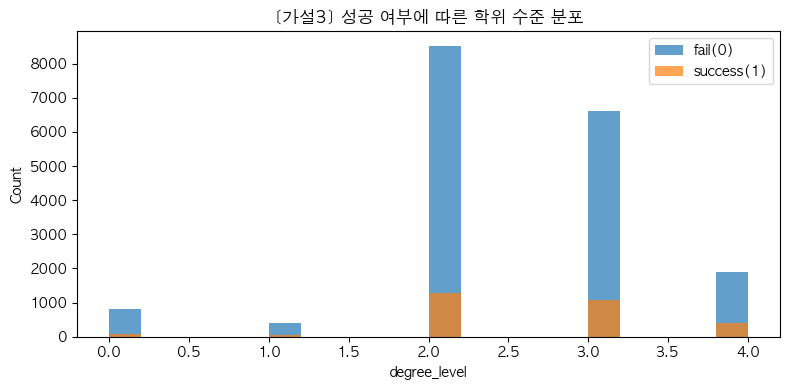

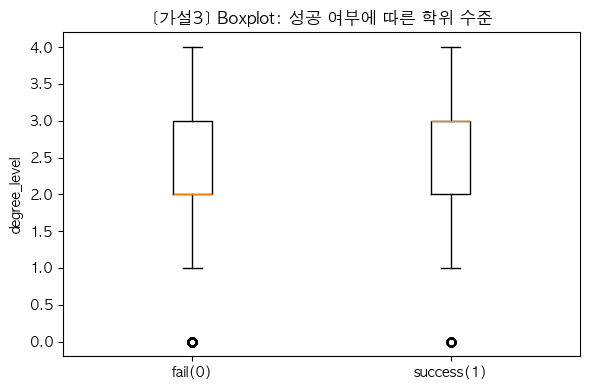

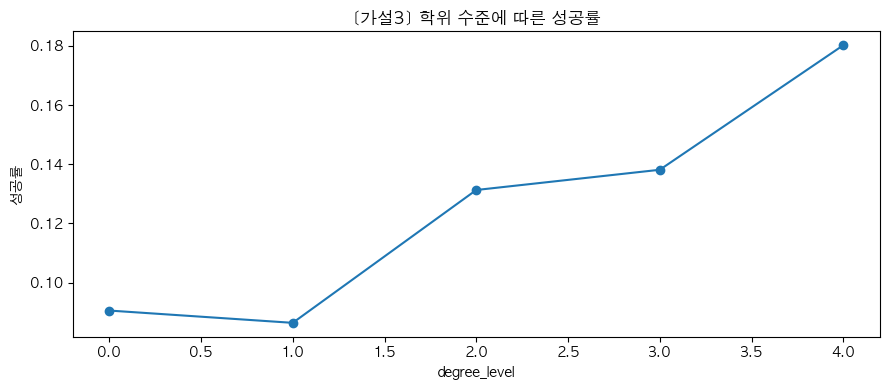


[정규성 체크]
fail: {'n': 18229, 'test': 'Normaltest(K2)', 'p': np.float64(2.82664241303768e-230), 'normal': np.False_}
success: {'n': 2882, 'test': 'Shapiro', 'p': np.float64(1.158143752990276e-47), 'normal': np.False_}

[등분산 체크]
{'test': 'Levene(median)', 'p': np.float64(0.16404773424032795), 'equal_var': np.True_}

[가설3] 사용한 검정: Mann–Whitney U (비모수)
p-value: 5.815894112091534e-11
Effect size: {'cliffs_delta(success-fail)': np.float64(0.06987525767579696)}

[가설3] Logistic regression (odds ratio)
coef p-value: 3.645531810567363e-13
Odds Ratio (per +1 degree level): 1.1877298830163543

🧾 [가설 3 결과 해석]
- p=5.816e-11 < 0.05 이므로 [학위 수준과 성공률은 통계적으로 유의한 차이]가 있습니다.
- 효과크기는 작음
- 로지스틱 기준: 학위 1단계 증가 시 성공 odds가 약 1.188배로 증가합니다(p=3.646e-13).

🚀 [후속 방향성 제안]
1) 인과로 단정 금지: 학위는 네트워크/산업 선택/자본 접근성과 얽힐 수 있음 → 통제변수 포함한 다변량 로지스틱으로 '학위의 독립 효과' 확인
2) 학위가 높은 그룹에서 특히 강한 산업/카테고리가 있는지(IT/바이오 등) 교차분석(학위×카테고리) 추천
3) VC 액션: 딜 소싱/심사에서 '학위'를 단독 컷오프로 쓰기보다는, 팀 구성/산업/투자규모와 함께 스코어링 요소로 활용


In [22]:
# =========================
# 가설 3 설정
# =========================
deg_col = "degree_level"  # 최종 학위 수준
target = "success_flag"
alpha = 0.05

# -------------------------
# 0) 안전 전처리
# -------------------------
tmp_deg = df[[deg_col, target]].copy()
tmp_deg[deg_col] = pd.to_numeric(tmp_deg[deg_col], errors="coerce")
tmp_deg = tmp_deg.dropna(subset=[deg_col, target]).copy()
tmp_deg[target] = tmp_deg[target].astype(int)

# 성공/실패 그룹 분리
g0_deg = tmp_deg[tmp_deg[target] == 0][deg_col]  # 실패
g1_deg = tmp_deg[tmp_deg[target] == 1][deg_col]  # 성공

print("분석 표본 수:", len(tmp_deg))
print("fail n:", len(g0_deg), "| success n:", len(g1_deg))
print(tmp_deg[deg_col].describe())

# =========================
# 1) 시각화 1: 성공/실패별 학위레벨 분포(히스토그램)
# =========================
plt.figure(figsize=(8,4))
plt.hist(g0_deg, bins=20, alpha=0.7, label="fail(0)")
plt.hist(g1_deg, bins=20, alpha=0.7, label="success(1)")
plt.xlabel(deg_col)
plt.ylabel("Count")
plt.title("[가설3] 성공 여부에 따른 학위 수준 분포")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 2) 시각화 2: 박스플롯(그룹 간 중앙값/분산 비교)
# =========================
plt.figure(figsize=(6,4))
plt.boxplot([g0_deg.dropna(), g1_deg.dropna()], labels=["fail(0)", "success(1)"])
plt.ylabel(deg_col)
plt.title("[가설3] Boxplot: 성공 여부에 따른 학위 수준")
plt.tight_layout()
plt.show()

# =========================
# 3) 시각화 3: 학위 레벨별 성공률(서열형 관점)
# =========================
deg_rate_df = (
    tmp_deg.groupby(deg_col)[target]
       .agg(success_rate="mean", n="count")
       .reset_index()
       .sort_values(deg_col)
)

plt.figure(figsize=(9,4))
plt.plot(deg_rate_df[deg_col].astype(int), deg_rate_df["success_rate"], marker="o")
plt.xlabel(deg_col)
plt.ylabel("성공률")
plt.title("[가설3] 학위 수준에 따른 성공률")
plt.tight_layout()
plt.show()

# =========================
# 4) 정규성/등분산 체크 (필요한 경우만)
#  - 정규성 H0: 정규분포를 따른다
#  - 등분산 H0: 두 그룹의 분산이 같다
# =========================
def check_normality(x, alpha=0.05):
    x = pd.Series(x).dropna().astype(float)
    n = len(x)
    if n < 8:
        return {"n": n, "test": None, "p": np.nan, "normal": None}
    if n <= 5000:
        stat, p = stats.shapiro(x)
        return {"n": n, "test": "Shapiro", "p": p, "normal": (p >= alpha)}
    stat, p = stats.normaltest(x)
    return {"n": n, "test": "Normaltest(K2)", "p": p, "normal": (p >= alpha)}

def check_equal_var(a, b, alpha=0.05):
    a = pd.Series(a).dropna().astype(float)
    b = pd.Series(b).dropna().astype(float)
    stat, p = stats.levene(a, b, center="median")
    return {"test": "Levene(median)", "p": p, "equal_var": (p >= alpha)}

norm0 = check_normality(g0_deg, alpha=alpha)
norm1 = check_normality(g1_deg, alpha=alpha)
ev = check_equal_var(g0_deg, g1_deg, alpha=alpha)

print("\n[정규성 체크]")
print("fail:", norm0)
print("success:", norm1)
print("\n[등분산 체크]")
print(ev)

# =========================
# 5) 통계검정 선택 + 실행
# -------------------------
# H0(귀무가설): 성공/실패 그룹 간 학위레벨(분포/평균) 차이가 없다.
# H1(대립가설): 차이가 있다. (가설 방향은 성공 그룹이 더 높다를 기대)
# =========================
def cohens_d(a, b):
    a = pd.Series(a).dropna().astype(float)
    b = pd.Series(b).dropna().astype(float)
    n1, n2 = len(a), len(b)
    s1, s2 = a.std(ddof=1), b.std(ddof=1)
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    return (a.mean() - b.mean()) / sp

def cliffs_delta(a, b):
    a = pd.Series(a).dropna().astype(float).values
    b = pd.Series(b).dropna().astype(float).values
    m, n = len(a), len(b)
    gt = sum(ai > bj for ai in a for bj in b)
    lt = sum(ai < bj for ai in a for bj in b)
    return (gt - lt) / (m*n)

# 자동 선택
if (norm0["normal"] is True) and (norm1["normal"] is True):
    # 정규성 OK → t-test 계열
    if ev["equal_var"] is True:
        stat, p = stats.ttest_ind(g1_deg, g0_deg, equal_var=True, nan_policy="omit")
        test_used = "Student t-test (모수)"
    else:
        stat, p = stats.ttest_ind(g1_deg, g0_deg, equal_var=False, nan_policy="omit")
        test_used = "Welch t-test (모수, 등분산X)"
else:
    stat, p = mannwhitneyu(g1_deg, g0_deg, alternative="two-sided")
    test_used = "Mann–Whitney U (비모수)"

print(f"\n[가설3] 사용한 검정: {test_used}")
print("p-value:", p)

# 유의할 때만 효과크기(규칙 준수)
effect = None
if p < alpha:
    if "t-test" in test_used:
        effect = {"cohens_d(success-fail)": cohens_d(g1_deg, g0_deg)}
    else:
        effect = {"cliffs_delta(success-fail)": cliffs_delta(g1_deg, g0_deg)}
print("Effect size:", effect)

# =========================
# 6) (권장) 로지스틱 회귀: 학위 1단계 증가 시 성공 odds 변화(OR)
# -------------------------
# H0: beta(학위)=0
# H1: beta(학위)≠0
# =========================
X = sm.add_constant(tmp_deg[[deg_col]])
y = tmp_deg[target].astype(int)
logit = sm.Logit(y, X).fit(disp=0)

or_value = float(np.exp(logit.params[deg_col]))
p_logit = float(logit.pvalues[deg_col])

print("\n[가설3] Logistic regression (odds ratio)")
print("coef p-value:", p_logit)
print("Odds Ratio (per +1 degree level):", or_value)

# =========================
# 7) 조건문 기반 결과 해석 + 이후 방향성(자동 출력)
# =========================
print("\n🧾 [가설 3 결과 해석]")
if p < alpha:
    # 효과크기 해석(대략)
    eff_txt = ""
    if effect is not None:
        if "cohens_d" in list(effect.keys())[0]:
            d = list(effect.values())[0]
            if abs(d) < 0.2:
                eff_txt = "효과크기는 작음(차이는 있지만 실무 임팩트는 제한적일 수 있음)"
            elif abs(d) < 0.5:
                eff_txt = "효과크기는 중간 이하(심사 체크리스트 신호로는 쓸 만함)"
            else:
                eff_txt = "효과크기는 중간 이상(포트폴리오 구성 신호로 의미 가능)"
        else:
            cd = list(effect.values())[0]
            if abs(cd) < 0.147:
                eff_txt = "효과크기는 작음"
            elif abs(cd) < 0.33:
                eff_txt = "효과크기는 중간 이하"
            else:
                eff_txt = "효과크기는 중간 이상"

    print(f"- p={p:.4g} < {alpha} 이므로 [학위 수준과 성공률은 통계적으로 유의한 차이]가 있습니다.")
    if eff_txt:
        print(f"- {eff_txt}")

    # 로지스틱 OR도 함께 해석(더 직관적)
    if p_logit < alpha:
        direction = "증가" if or_value > 1 else "감소"
        print(f"- 로지스틱 기준: 학위 1단계 증가 시 성공 odds가 약 {or_value:.3f}배로 {direction}합니다(p={p_logit:.4g}).")

    print("\n🚀 [후속 방향성 제안]")
    print("1) 인과로 단정 금지: 학위는 네트워크/산업 선택/자본 접근성과 얽힐 수 있음 → 통제변수 포함한 다변량 로지스틱으로 '학위의 독립 효과' 확인")
    print("2) 학위가 높은 그룹에서 특히 강한 산업/카테고리가 있는지(IT/바이오 등) 교차분석(학위×카테고리) 추천")
    print("3) VC 액션: 딜 소싱/심사에서 '학위'를 단독 컷오프로 쓰기보다는, 팀 구성/산업/투자규모와 함께 스코어링 요소로 활용")
else:
    print(f"- p={p:.4g} ≥ {alpha} 이므로 [학위 수준이 성공률과 유의한 차이가 있다고 보기 어렵습니다](H0 기각 불가).")
    print("  (표본수/분포/학위 정의 방식에 따라 결과가 달라질 수 있음)")

    print("\n🚀 [후속 방향성 제안]")
    print("1) 학위레벨이 너무 거칠거나 결측이 많을 수 있음 → 학위 레벨 재코딩/결측 처리 방식 점검")
    print("2) '최고 학위' 대신 '고학위 보유자 비율(석/박 비율)' 같은 회사단위 지표로 재정의해 재검정")
    print("3) 학위보다 더 직접적인 변수(IT 전공 비율, 투자 템포, 관계 변화량, 회사 규모)가 더 강할 가능성 → 다변량 모델에서 상대 중요도 비교")


### 가설4) IT 전공 창업자 회사의 성공률이 높은가?

- Computer Science / Software, AI / Data / Robotics 그룹 vs 나머지 전공
- H0(귀무가설): IT 전공 창업자 회사와 비IT 전공 창업자 회사의 성공률은 같다. (독립)
- H1(대립가설): 두 그룹의 성공률은 다르다. (차이 존재)

- 사용 검정 / 이유

      - IT 여부(0/1) × success_flag(0/1) → 범주형 vs 범주형
      - 표본이 충분하면 카이제곱 독립성 검정
      - 셀 기대빈도가 작으면 Fisher exact test
      - 유의하면 효과크기(Cramer’s V) + 오즈비(OR) 로 “실무적으로 얼마나 차이나는지”까지 설명

In [23]:
print(df["rel_cf_id"].nunique())
print(len(df))

40064
59212


In [24]:
df['subject'].value_counts()
df

,rel_p_id,founder_ever_success,rel_cf_id,n_founding,is_past,sequence,birthplace,degree_level,subject,institution,graduated_at,objects_cfpr_id,success_flag,relationships,category,company_size
0,p:10,1,c:5,1,0,1,NaN,NaN,Computer Science / Software,harvard university,NaN,c:5,1,269.000,social,대형팀
1,p:100009,0,c:152329,2,0,1,NaN,NaN,NaN,NaN,NaN,c:152329,0,2.000,software,중형팀
2,p:100009,0,c:81559,2,0,2,NaN,NaN,NaN,NaN,NaN,c:81559,0,2.000,consulting,중형팀
3,p:100017,0,c:81564,1,0,1,NaN,NaN,NaN,NaN,NaN,c:81564,0,15.000,medical,대형팀
4,p:100025,0,c:287,1,0,1,NaN,NaN,NaN,NaN,NaN,c:287,0,21.000,games_video,대형팀
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59511,p:99982,1,c:16993,2,1,1,NaN,NaN,NaN,NaN,NaN,c:16993,1,2.000,games_video,중형팀
59512,p:99982,1,c:81541,2,0,2,NaN,NaN,NaN,NaN,NaN,c:81541,0,3.000,software,대형팀
59513,p:99988,0,c:64683,1,0,1,NaN,2.000,Computer Science / Software,bristol university,2004-01-01,c:64683,0,1.000,software,소형팀
59514,p:99994,0,c:3643,1,0,1,NaN,2.000,Marketing / Communications,"madras, india university",NaN,c:3643,0,3.000,public_relations,대형팀


In [25]:
it_majors = {"Computer Science / Software", "AI / Data / Robotics"}

# 0) 필요한 컬럼만 복사
base = df[["rel_cf_id", "success_flag", "subject"]].copy()

base["success_flag"] = pd.to_numeric(base["success_flag"], errors="coerce")
base = base.dropna(subset=["rel_cf_id", "success_flag"]).copy()
base["success_flag"] = base["success_flag"].astype(int)

# subject 정리
base["subject"] = base["subject"].replace(["nan", "None", "NULL", ""], np.nan)

# 1) 회사 단위 집계
company_major = (
    base.groupby("rel_cf_id")
        .agg(
            success_flag=("success_flag", "max"),          # 회사 성공 여부 (0/1이면 max=OR)
            is_it_any=("subject", lambda s: s.isin(it_majors).any()),  # IT 전공 하나라도 있나?
            n_subject=("subject", "nunique")               # 회사 내 전공 다양성(옵션)
        )
        .reset_index()
)

company_major["is_it_any"] = company_major["is_it_any"].astype(int)

print(company_major.shape)
print(company_major["is_it_any"].value_counts())
company_major.head()

# 가장 추천: is_it_any 기반
df_company = company_major.copy()

# 검정용 컬럼명 통일
df_company = df_company.rename(columns={"is_it_any": "is_it_major"})
df_company[["rel_cf_id", "success_flag", "is_it_major"]].head()

(40064, 4)
is_it_any
0    31369
1     8695
Name: count, dtype: int64


,rel_cf_id,success_flag,is_it_major
0,c:1,1,1
1,c:10,1,1
2,c:100,1,1
3,c:10002,0,1
4,c:100062,0,0


분석 표본(회사 단위): 40064
is_it_major
0    31369
1     8695
Name: count, dtype: int64
success_flag
0    36329
1     3735
Name: count, dtype: int64


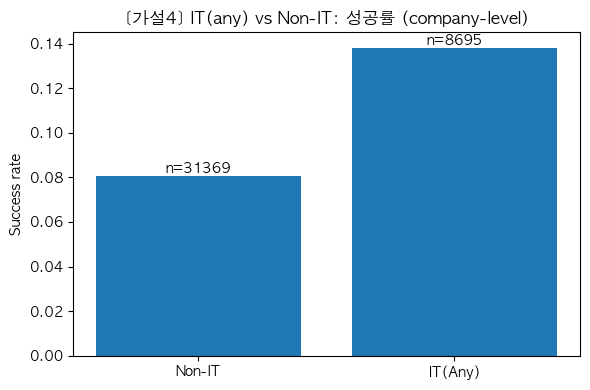

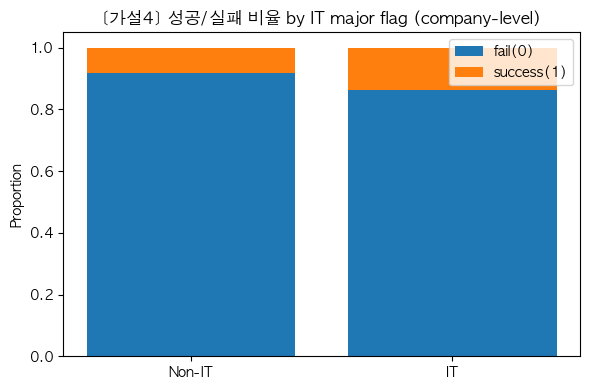


[IT vs Non-IT] Test result (company-level)
Contingency table:
 success_flag      0     1
is_it_major              
0             28835  2534
1              7494  1201
Test used: Chi-square independence test (2x2)
p-value: 2.1328308440206993e-59
min expected: 810.5986671325878

Effect size (only if significant): {'cramers_v': np.float64(0.08119922270321286), 'odds_ratio_logit': 1.8236549249923475}

🧾 [결과 해석]
- p=2.133e-59 < 0.05 → [IT 전공 보유 여부에 따라 성공률 차이가 유의]합니다.
- Cramer's V=0.081 → 효과크기는 작음(유의하지만 단독 신호는 약할 수 있음)
- OR=1.824 → IT 보유 회사의 성공 odds가 Non-IT 대비 1.82배 높음(p=3.267e-58).

 [비즈니스 해석]
- IT 전공 보유는 기술 실행력/제품 개발 역량과 연결될 수 있어 성공률 차이가 나타날 수 있습니다.
- 다만 ‘산업 선택(IT 분야 창업)’, ‘투자금/규모’, ‘팀 구성’이 함께 작용했을 가능성이 큼(인과 단정 금지).

 [후속 방향성]
1) 통제변수 포함 로지스틱으로 ‘독립효과’ 확인: company_size, total_invested, n_milestone, n_title 등을 넣고도 IT 효과가 유지되는지 보기
2) 산업카테고리로 층화(IT 산업 내 비교)하면 더 공정한 비교가 됨
3) IT 정의 민감도 분석: 'IT(any)' 대신 'IT 비율(it_major_ratio)'로 재검정


In [26]:
alpha = 0.05
target = "success_flag"
flag_col = "is_it_major"   # 이미 집계된 IT 여부(0/1)

# -------------------------
# 0) 데이터 준비 (df_company 사용)
# -------------------------
tmp_it = df_company[[flag_col, target]].copy()
tmp_it[flag_col] = pd.to_numeric(tmp_it[flag_col], errors="coerce")
tmp_it[target]   = pd.to_numeric(tmp_it[target], errors="coerce")

tmp_it = tmp_it.dropna(subset=[flag_col, target]).copy()
tmp_it[flag_col] = tmp_it[flag_col].astype(int)
tmp_it[target]   = tmp_it[target].astype(int)

print("분석 표본(회사 단위):", len(tmp_it))
print(tmp_it[flag_col].value_counts())
print(tmp_it[target].value_counts())

# =========================
# 1) 시각화: IT vs Non-IT 성공률(+표본수)
# =========================
rate_df = (
    tmp_it.groupby(flag_col)[target]
       .agg(success_rate="mean", n="count")
       .reset_index()
)
rate_df["group"] = rate_df[flag_col].map({0: "Non-IT", 1: "IT(Any)"})

plt.figure(figsize=(6,4))
plt.bar(rate_df["group"], rate_df["success_rate"])
for i, row in rate_df.iterrows():
    plt.text(i, row["success_rate"], f"n={int(row['n'])}", ha="center", va="bottom")
plt.ylabel("Success rate")
plt.title("[가설4] IT(any) vs Non-IT: 성공률 (company-level)")
plt.tight_layout()
plt.show()

# 성공/실패 비율 스택
ct_ratio = pd.crosstab(tmp_it[flag_col], tmp_it[target], normalize="index")
plt.figure(figsize=(6,4))
plt.bar(["Non-IT","IT"], ct_ratio.get(0,0), label="fail(0)")
plt.bar(["Non-IT","IT"], ct_ratio.get(1,0), bottom=ct_ratio.get(0,0), label="success(1)")
plt.ylabel("Proportion")
plt.title("[가설4] 성공/실패 비율 by IT major flag (company-level)")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 2) 통계검정: Chi-square 또는 Fisher 
from scipy.stats import fisher_exact
# =========================
ct = pd.crosstab(tmp_it[flag_col], tmp_it[target])  # 2x2
chi2, p_chi, dof, expected = chi2_contingency(ct)

min_expected = expected.min()
use_fisher = (min_expected < 5)

if use_fisher:
    oddsratio_fisher, p = fisher_exact(ct.values)
    test_used = "Fisher's exact test (2x2, 기대빈도 작음)"
else:
    p = p_chi
    test_used = "Chi-square independence test (2x2)"

print("\n=========================")
print("[IT vs Non-IT] Test result (company-level)")
print("Contingency table:\n", ct)
print("Test used:", test_used)
print("p-value:", p)
print("min expected:", min_expected)
print("=========================\n")

# =========================
# 3) 유의할 때만 효과크기 계산
# =========================
effect = None
or_value = None
p_or = None

if p < alpha:
    n_total = ct.to_numpy().sum()
    cramers_v = np.sqrt((chi2 / n_total) / (min(ct.shape[0]-1, ct.shape[1]-1)))

    # 로지스틱으로 OR (IT=1 vs 0)
    X = sm.add_constant(tmp_it[[flag_col]])
    y = tmp_it[target].astype(int)
    m = sm.Logit(y, X).fit(disp=0)

    or_value = float(np.exp(m.params[flag_col]))
    p_or = float(m.pvalues[flag_col])

    effect = {"cramers_v": cramers_v, "odds_ratio_logit": or_value}

print("Effect size (only if significant):", effect)

# =========================
# 4) 조건문 기반 해석 + 이후 방향성
# =========================
print("\n🧾 [결과 해석]")
if p < alpha:
    v = effect["cramers_v"]
    if v < 0.1:
        eff_txt = "효과크기는 작음(유의하지만 단독 신호는 약할 수 있음)"
    elif v < 0.3:
        eff_txt = "효과크기는 중간 이하(심사/소싱 보조 신호로 유용)"
    else:
        eff_txt = "효과크기는 중간 이상(포트폴리오 전략 신호로 의미 가능)"

    print(f"- p={p:.4g} < {alpha} → [IT 전공 보유 여부에 따라 성공률 차이가 유의]합니다.")
    print(f"- Cramer's V={v:.3f} → {eff_txt}")

    if p_or is not None and p_or < alpha:
        direction = "높음" if or_value > 1 else "낮음"
        print(f"- OR={or_value:.3f} → IT 보유 회사의 성공 odds가 Non-IT 대비 {or_value:.2f}배 {direction}(p={p_or:.4g}).")

    print("\n [비즈니스 해석]")
    print("- IT 전공 보유는 기술 실행력/제품 개발 역량과 연결될 수 있어 성공률 차이가 나타날 수 있습니다.")
    print("- 다만 ‘산업 선택(IT 분야 창업)’, ‘투자금/규모’, ‘팀 구성’이 함께 작용했을 가능성이 큼(인과 단정 금지).")

    print("\n [후속 방향성]")
    print("1) 통제변수 포함 로지스틱으로 ‘독립효과’ 확인: company_size, total_invested, n_milestone, n_title 등을 넣고도 IT 효과가 유지되는지 보기")
    print("2) 산업카테고리로 층화(IT 산업 내 비교)하면 더 공정한 비교가 됨")
    print("3) IT 정의 민감도 분석: 'IT(any)' 대신 'IT 비율(it_major_ratio)'로 재검정")
else:
    print(f"- p={p:.4g} ≥ {alpha} → [IT 보유 vs Non-IT 성공률 차이를 유의하게 확인하지 못했습니다](H0 기각 불가).")

    print("\n [비즈니스 해석]")
    print("- IT 전공 보유 자체가 성공을 가르는 핵심 신호가 아닐 수 있고,")
    print("- 성공은 시장/투자 시점/팀 완성도/자본 규모 등에 의해 더 크게 좌우될 수 있습니다.")

    print("\n [후속 방향성]")
    print("1) IT 정의를 바꿔 민감도 분석(대표전공/비율/핵심기술 직무 포함 등)")
    print("2) company_size 통제 후에도 차이가 나타나는지 확인(다변량 로지스틱)")

### 가설5) 전공 - 회사 카테고리 일치 시 성공률이 높은가?

   - 검정 : match(0/1) vs success(0/1) -> 카이제곱
   - 이유 : 이진 - 이진 독립성 검정

        - H0 : 전공-카테고리 일치 여부와 성공은 독립
        - H1 : 독립 아님

        - 효과크기 : Cramer's V

major_cat_match
0    10746
1     7533
Name: count, dtype: int64
                 mean  count
major_cat_match             
0               0.145  10746
1               0.109   7533


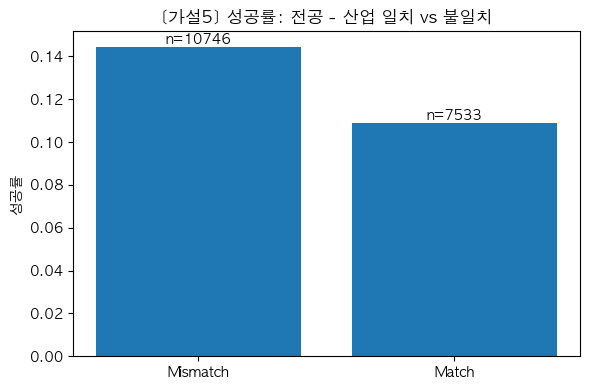


[가설5] Chi-square independence test
table:
 success_flag        0     1
major_cat_match            
0                9193  1553
1                6712   821
chi2: 49.161157614447234 | dof: 1 | p-value: 2.357734437561964e-12
Effect size (Cramer's V): 0.05186027722202129

[가설5] Logistic (for OR interpretation)
p-value: 2.3344645003527634e-12 | Odds Ratio(Match vs Mismatch): 0.7240640975558091

🧾 [가설 5 결과 해석]
- p=2.358e-12 < 0.05 → [전공-카테고리 일치 여부와 성공률은 유의하게 연관]이 있습니다.
- Cramer's V=0.052 → 효과크기는 작음(통계적으로는 차이가 있지만 실무 임팩트는 제한적일 수 있음)
- OR=0.724 → (의외 결과) 일치가 성공 odds를 낮추는 방향입니다. 매핑/정의 재점검 필요.

🚀 [후속 방향성 제안]
1) 버킷 매핑(major_to_bucket / category_to_bucket) 룰이 결과를 좌우할 수 있음 → 전공/카테고리 원문 상위값 기반으로 매핑 정교화
2) 산업별로 효과가 다를 수 있음 → '산업(카테고리) 층화 분석' 또는 (매치×카테고리) 상호작용 로지스틱으로 확장
3) 인과로 단정 금지: 좋은 시장/투자금/네트워크가 함께 작용했을 수 있음 → size_bin, total_invested, diff_tot_cur_rel 등을 통제한 다변량 로지스틱으로 '독립 효과' 확인
4) VC 활용: 초기 심사에서 'Founding team의 도메인 적합성(전공-산업 일치)'을 리스크 완화 신호로 사용 가능(단, 과적합 방지 위해 다른 지표와 함께)


In [27]:
# =========================
# 가설 5 설정
# =========================
subject_col = "subject"               # 창업자 대표 전공(회사단위)
cat_col     = "category"              # 회사 카테고리
target      = "success_flag"
alpha       = 0.05

# -------------------------
# 0) 안전 전처리
# -------------------------
tmp_subject = df[[subject_col, cat_col, target]].copy()
tmp_subject[subject_col] = tmp_subject[subject_col].replace(["nan", "None", "NULL", ""], np.nan)
tmp_subject[cat_col]   = tmp_subject[cat_col].replace(["nan", "None", "NULL", ""], np.nan)
tmp_subject[target]    = pd.to_numeric(tmp_subject[target], errors="coerce")

tmp_subject = tmp_subject.dropna(subset=[subject_col, cat_col, target]).copy()
tmp_subject[target] = tmp_subject[target].astype(int)

# =========================
# 1) 전공/카테고리 버킷 매핑(프로젝트 기준으로 조정 가능)
#  - "일치" 여부를 만들기 위해 공통 기준의 큰 범주로 묶음
# =========================
def major_to_bucket(x):
    x = str(x).lower()
    if any(k in x for k in ["computer","software","it","information","informatics","data","ai","machine learning","ml","robot"]):
        return "IT"
    if any(k in x for k in ["bio","medical","pharma","health","biotech"]):
        return "Bio/Med"
    if any(k in x for k in ["business","mba","management","econom","finance","account"]):
        return "Biz/Fin"
    if any(k in x for k in ["electrical","mechanical","industrial","engineering","chemical","materials"]):
        return "Engineering"
    return "Other"

def category_to_bucket(x):
    x = str(x).lower()
    if any(k in x for k in ["software","internet","mobile","saas","ai","data","cloud","it"]):
        return "IT"
    if any(k in x for k in ["health","bio","medical","pharma","biotech"]):
        return "Bio/Med"
    if any(k in x for k in ["finance","fintech","bank","insurance","payment"]):
        return "Biz/Fin"
    if any(k in x for k in ["manufacturing","hardware","robot","energy","semiconductor","industrial"]):
        return "Engineering"
    return "Other"

tmp_subject["major_bucket"] = tmp_subject[subject_col].apply(major_to_bucket)
tmp_subject["cat_bucket"]   = tmp_subject[cat_col].apply(category_to_bucket)

# 전공-카테고리 일치 여부 (1=일치, 0=불일치)
tmp_subject["major_cat_match"] = (tmp_subject["major_bucket"] == tmp_subject["cat_bucket"]).astype(int)

print(tmp_subject["major_cat_match"].value_counts(dropna=False))
print(tmp_subject.groupby("major_cat_match")[target].agg(["mean","count"]))

# =========================
# 시각화: 일치/불일치 성공률
# =========================
plot_df = (
    tmp_subject.groupby("major_cat_match")[target]
       .agg(success_rate="mean", n="count")
       .reset_index()
)
plot_df["label"] = plot_df["major_cat_match"].map({0:"Mismatch", 1:"Match"})

plt.figure(figsize=(6,4))
plt.bar(plot_df["label"], plot_df["success_rate"])
for i, row in plot_df.iterrows():
    plt.text(i, row["success_rate"], f"n={int(row['n'])}", ha="center", va="bottom")
plt.ylabel("성공률")
plt.title("[가설5] 성공률: 전공 - 산업 일치 vs 불일치")
plt.tight_layout()
plt.show()

# =========================
# 카이제곱 검정
# =========================
ct_subject = pd.crosstab(tmp_subject["major_cat_match"], tmp_subject[target])
chi2, p, dof, expected = chi2_contingency(ct_subject)

# Cramer's V
n_total = ct_subject.to_numpy().sum()
r, k = ct_subject.shape
cramers_v = np.sqrt((chi2 / n_total) / (min(r-1, k-1)))

print("\n=========================")
print("[가설5] Chi-square independence test")
print("table:\n", ct_subject)
print("chi2:", chi2, "| dof:", dof, "| p-value:", p)
print("Effect size (Cramer's V):", cramers_v)
print("=========================\n")

# =========================
# (유의할 때만) OR 계산: 해석이 쉬운 효과크기
#  - OR > 1 이면 "일치"가 성공 odds를 높이는 방향
# =========================
or_value = None
p_or = None
if p < alpha:
    # 로지스틱 회귀(이진 설명변수 1개) → OR 도출
    X = sm.add_constant(tmp_subject[["major_cat_match"]])
    y = tmp_subject[target].astype(int)
    m = sm.Logit(y, X).fit(disp=0)

    or_value = float(np.exp(m.params["major_cat_match"]))
    p_or = float(m.pvalues["major_cat_match"])

    print("[가설5] Logistic (for OR interpretation)")
    print("p-value:", p_or, "| Odds Ratio(Match vs Mismatch):", or_value)

    print("\n🧾 [가설 5 결과 해석]")
if p < alpha:
    # Cramer's V 해석(대략)
    if cramers_v < 0.1:
        eff_txt = "효과크기는 작음(통계적으로는 차이가 있지만 실무 임팩트는 제한적일 수 있음)"
    elif cramers_v < 0.3:
        eff_txt = "효과크기는 중간 이하(투자 심사 체크리스트 신호로 고려 가능)"
    else:
        eff_txt = "효과크기는 중간 이상(포트폴리오 구성/심사 기준에 반영 가치가 큼)"

    print(f"- p={p:.4g} < {alpha} → [전공-카테고리 일치 여부와 성공률은 유의하게 연관]이 있습니다.")
    print(f"- Cramer's V={cramers_v:.3f} → {eff_txt}")

    # OR 기반 해석(유의 시에만 계산)
    if or_value is not None and p_or is not None and p_or < alpha:
        if or_value > 1:
            print(f"- OR={or_value:.3f} → 전공-카테고리가 '일치'할 때 성공 odds가 약 {or_value:.2f}배 높습니다.")
        else:
            print(f"- OR={or_value:.3f} → (의외 결과) 일치가 성공 odds를 낮추는 방향입니다. 매핑/정의 재점검 필요.")

    print("\n🚀 [후속 방향성 제안]")
    print("1) 버킷 매핑(major_to_bucket / category_to_bucket) 룰이 결과를 좌우할 수 있음 → 전공/카테고리 원문 상위값 기반으로 매핑 정교화")
    print("2) 산업별로 효과가 다를 수 있음 → '산업(카테고리) 층화 분석' 또는 (매치×카테고리) 상호작용 로지스틱으로 확장")
    print("3) 인과로 단정 금지: 좋은 시장/투자금/네트워크가 함께 작용했을 수 있음 → size_bin, total_invested, diff_tot_cur_rel 등을 통제한 다변량 로지스틱으로 '독립 효과' 확인")
    print("4) VC 활용: 초기 심사에서 'Founding team의 도메인 적합성(전공-산업 일치)'을 리스크 완화 신호로 사용 가능(단, 과적합 방지 위해 다른 지표와 함께)")
else:
    print(f"- p={p:.4g} ≥ {alpha} → [전공-카테고리 일치 여부가 성공률과 유의한 연관이 있다고 보기 어렵습니다](H0 기각 불가).")
    print(f"- Cramer's V={cramers_v:.3f} → (유의하지 않으므로 효과크기 해석은 보수적으로)")

    print("\n🚀 [후속 방향성 제안]")
    print("1) '일치' 정의가 너무 거칠거나 매핑이 부정확할 수 있음 → 전공/카테고리 세분화 또는 도메인 전문가 룰 반영")
    print("2) 표본이 분산되어 검정력이 낮을 수 있음 → IT/Bio/Fin 등 주요 산업군만 필터링하여 재검정")
    print("3) 전공-산업 일치보다 '팀 구성 다양성(직무 다양성), 투자 템포, 관계 변화량'이 더 강한 신호일 수 있음 → 다변량 모델로 상대 중요도 비교")

### 가설 6) 창업 경험 많은 창업자일수록 성공↑

여기서 “창업 경험”은 데이터에 따라 정의가 달라. 보통:

(A) founder가 과거에 참여한 회사 수(“serial entrepreneur count”)

(B) founder가 과거에 Founder 타이틀을 가진 회사 수

(C) founder_master에 경험 변수(예: founder_exp_cnt, num_prior_startups)가 있는 경우

- 검정: 경험(연속) vs 성공(이진) → 자동(t/Welch/MWU) 또는 로지스틱
- H0: 경험은 성공과 무관
- H1: 관련 있음
- 효과크기: (유의 시) Cohen’s d/Cliff’s delta + OR

In [28]:
founding_result = test_continuous_vs_binary(df, x='n_founding', do_checks=True)
print(founding_result["test"], founding_result["p"], founding_result["effect"])

tmp = df[['n_founding', "success_flag"]].dropna()
X = sm.add_constant(tmp[['n_founding']])
y = tmp["success_flag"].astype(int)
m = sm.Logit(y, X).fit(disp=0)
print("Odds Ratio:", np.exp(m.params))

Mann–Whitney U 4.292362930244398e-17 {'cliffs_delta': np.float64(0.050778852638050674)}
Odds Ratio: const        0.109
n_founding   1.071
dtype: float64


분석 표본: 59212 | fail: 52814 | success: 6398
count   59212.000
mean        1.492
std         1.099
min         1.000
25%         1.000
50%         1.000
75%         2.000
max        21.000
Name: n_founding, dtype: float64
n_founding 값 분포(상위 20):
 n_founding
1     42506
2      9994
3      4052
4      1466
5       604
6       281
7        98
9        53
8        45
12       35
11       21
21       21
16       15
13       12
10        9
Name: count, dtype: int64


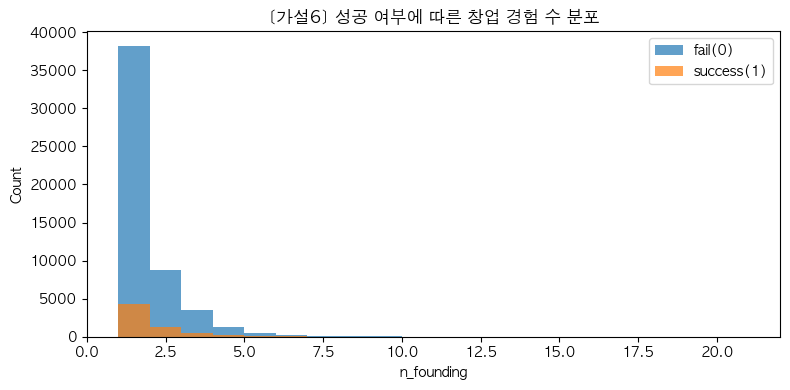

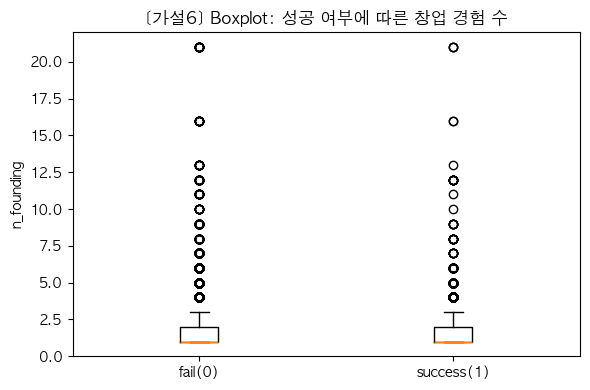

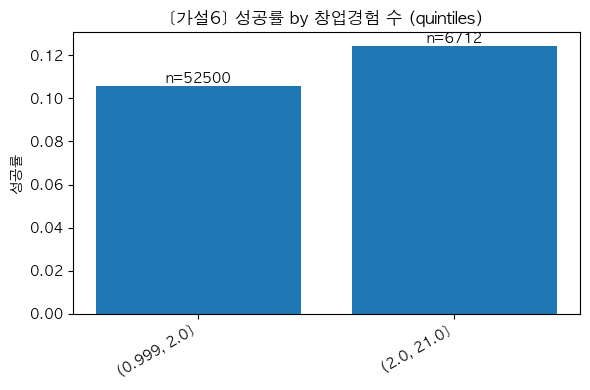


[정규성 체크]
fail: {'n': 52814, 'test': 'Normaltest(K2)', 'p': np.float64(0.0), 'normal': np.False_}
success: {'n': 6398, 'test': 'Normaltest(K2)', 'p': np.float64(0.0), 'normal': np.False_}

[등분산 체크]
{'test': 'Levene(median)', 'p': np.float64(2.3111985808651547e-11), 'equal_var': np.False_}

[가설6] 사용한 검정: Mann–Whitney U (비모수)
p-value: 4.292362930244398e-17
Effect size: {'cliffs_delta(success-fail)': np.float64(0.050778852638050674)}

[가설6] Logistic regression (Odds Ratio)
coef p-value: 3.434426046116306e-11
Odds Ratio (per +1 n_founding): 1.0709612424958446

🧾 [가설 6 결과 해석]
- p=4.292e-17 < 0.05 → [창업 경험(n_founding)과 성공률은 통계적으로 유의한 차이/연관]이 있습니다.
- 효과크기는 작음
- 로지스틱 기준: n_founding 1 증가 시 성공 odds가 약 1.071배로 증가(p=3.434e-11).

🚀 [후속 방향성 제안]
1) 분포가 '0이 많고 긴 꼬리'일 가능성이 큼 → log(1+n_founding) 변환 후 로지스틱 재검증(안정적)
2) 통제변수 포함: 경험 많은 창업자는 네트워크/자본 접근성이 함께 높을 수 있음 → size_bin, total_invested, diff_tot_cur_rel 등을 통제한 다변량 로지스틱으로 '독립 효과' 확인
3) 산업별로 경험의 가치가 다를 수 있음 → IT/Bio/Fin 등 카테고리 층화 분석 또는 상호작용(n_founding×ca

In [29]:
# =========================
# 가설 6 설정
# =========================
exp_col = "n_founding"   # 창업 경험(=창업한 회사 수)
target  = "success_flag"
alpha   = 0.05

# -------------------------
# 0) 안전 전처리
# -------------------------
tmp_founding = df[[exp_col, target]].copy()
tmp_founding[exp_col] = pd.to_numeric(tmp_founding[exp_col], errors="coerce")
tmp_founding[target]  = pd.to_numeric(tmp_founding[target], errors="coerce")
tmp_founding = tmp_founding.dropna(subset=[exp_col, target]).copy()
tmp_founding[target] = tmp_founding[target].astype(int)

# 경험이 0 미만 같은 이상치가 있으면 제거(필요 시)
tmp_founding = tmp_founding[tmp_founding[exp_col] >= 0].copy()

g0_founding = tmp_founding[tmp_founding[target] == 0][exp_col]  # 실패
g1_founding = tmp_founding[tmp_founding[target] == 1][exp_col]  # 성공

print("분석 표본:", len(tmp_founding), "| fail:", len(g0_founding), "| success:", len(g1_founding))
print(tmp_founding[exp_col].describe())
print("n_founding 값 분포(상위 20):\n", tmp_founding[exp_col].value_counts().head(20))

# =========================
# 1) 시각화 1: 성공/실패별 n_founding 분포(히스토그램)
# =========================
plt.figure(figsize=(8,4))
plt.hist(g0_founding, bins=20, alpha=0.7, label="fail(0)")
plt.hist(g1_founding, bins=20, alpha=0.7, label="success(1)")
plt.xlabel(exp_col)
plt.ylabel("Count")
plt.title("[가설6] 성공 여부에 따른 창업 경험 수 분포")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 2) 시각화 2: 박스플롯(중앙값/분산 비교)
# =========================
plt.figure(figsize=(6,4))
plt.boxplot([g0_founding.values, g1_founding.values], labels=["fail(0)", "success(1)"])
plt.ylabel(exp_col)
plt.title("[가설6] Boxplot: 성공 여부에 따른 창업 경험 수")
plt.tight_layout()
plt.show()

# =========================
# 3) 시각화 3: 경험 구간별 성공률(분위수 bin)
#  - qcut: 표본이 비슷한 구간으로 나눠서 성공률 비교
# =========================
tmp_founding["exp_bin"] = pd.qcut(tmp_founding[exp_col], q=5, duplicates="drop")

rate_df_founding = (
    tmp_founding.groupby("exp_bin")[target]
       .agg(success_rate="mean", n="count")
       .reset_index()
)

plt.figure(figsize=(6,4))
plt.bar(rate_df_founding["exp_bin"].astype(str), rate_df_founding["success_rate"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("성공률")
plt.title("[가설6] 성공률 by 창업경험 수 (quintiles)")
for i, row in rate_df_founding.iterrows():
    plt.text(i, row["success_rate"], f"n={int(row['n'])}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# =========================
# 4) 정규성/등분산 체크
#  - 정규성 H0: 정규분포를 따른다
#  - 등분산 H0: 두 그룹 분산이 같다
# =========================
def check_normality(x, alpha=0.05):
    x = pd.Series(x).dropna().astype(float)
    n = len(x)
    if n < 8:
        return {"n": n, "test": None, "p": np.nan, "normal": None}
    if n <= 5000:
        stat, p = stats.shapiro(x)
        return {"n": n, "test": "Shapiro", "p": p, "normal": (p >= alpha)}
    stat, p = stats.normaltest(x)
    return {"n": n, "test": "Normaltest(K2)", "p": p, "normal": (p >= alpha)}

def check_equal_var(a, b, alpha=0.05):
    a = pd.Series(a).dropna().astype(float)
    b = pd.Series(b).dropna().astype(float)
    stat, p = stats.levene(a, b, center="median")
    return {"test": "Levene(median)", "p": p, "equal_var": (p >= alpha)}

norm0 = check_normality(g0_founding, alpha=alpha)
norm1 = check_normality(g1_founding, alpha=alpha)
ev = check_equal_var(g0_founding, g1_founding, alpha=alpha)

print("\n[정규성 체크]")
print("fail:", norm0)
print("success:", norm1)
print("\n[등분산 체크]")
print(ev)

# =========================
# 5) 통계검정 선택 + 실행
# -------------------------
# H0: 성공/실패 그룹 간 n_founding 차이가 없다.
# H1: 차이가 있다. (가설 방향은 success 그룹이 더 크길 기대)
#
# 사용 검정:
# - (정규성 OK) t-test / Welch
# - (정규성 X) Mann–Whitney U
# =========================
def cohens_d(a, b):
    a = pd.Series(a).dropna().astype(float)
    b = pd.Series(b).dropna().astype(float)
    n1, n2 = len(a), len(b)
    s1, s2 = a.std(ddof=1), b.std(ddof=1)
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    return (a.mean() - b.mean()) / sp

def cliffs_delta(a, b):
    a = pd.Series(a).dropna().astype(float).values
    b = pd.Series(b).dropna().astype(float).values
    m, n = len(a), len(b)
    gt = sum(ai > bj for ai in a for bj in b)
    lt = sum(ai < bj for ai in a for bj in b)
    return (gt - lt) / (m*n)

if (norm0["normal"] is True) and (norm1["normal"] is True):
    if ev["equal_var"] is True:
        stat, p = stats.ttest_ind(g1_founding, g0_founding, equal_var=True, nan_policy="omit")
        test_used = "Student t-test (모수)"
    else:
        stat, p = stats.ttest_ind(g1_founding, g0_founding, equal_var=False, nan_policy="omit")
        test_used = "Welch t-test (모수, 등분산X)"
else:
    stat, p = mannwhitneyu(g1_founding, g0_founding, alternative="two-sided")
    test_used = "Mann–Whitney U (비모수)"

print(f"\n[가설6] 사용한 검정: {test_used}")
print("p-value:", p)

# 유의할 때만 효과크기(규칙 5)
effect = None
if p < alpha:
    if "t-test" in test_used:
        effect = {"cohens_d(success-fail)": cohens_d(g1_founding, g0_founding)}
    else:
        effect = {"cliffs_delta(success-fail)": cliffs_delta(g1_founding, g0_founding)}
print("Effect size:", effect)

# =========================
# 6) (권장) 로지스틱 회귀: n_founding 1 증가 시 성공 odds 변화(OR)
#  - H0: beta=0
#  - H1: beta≠0
# =========================
X = sm.add_constant(tmp_founding[[exp_col]])
y = tmp_founding[target].astype(int)

logit = sm.Logit(y, X).fit(disp=0)
or_value = float(np.exp(logit.params[exp_col]))
p_logit  = float(logit.pvalues[exp_col])

print("\n[가설6] Logistic regression (Odds Ratio)")
print("coef p-value:", p_logit)
print("Odds Ratio (per +1 n_founding):", or_value)

# =========================
# 7) 조건문 기반 결과 해석 + 이후 방향성
# =========================
print("\n🧾 [가설 6 결과 해석]")
if p < alpha:
    eff_txt = ""
    if effect is not None:
        key = list(effect.keys())[0]
        val = list(effect.values())[0]
        if "cohens_d" in key:
            if abs(val) < 0.2:
                eff_txt = "효과크기는 작음(유의하지만 실무 임팩트는 제한적일 수 있음)"
            elif abs(val) < 0.5:
                eff_txt = "효과크기는 중간 이하(심사 체크리스트 신호로는 유용)"
            else:
                eff_txt = "효과크기는 중간 이상(포트폴리오 전략 신호로 의미 가능)"
        else:
            if abs(val) < 0.147:
                eff_txt = "효과크기는 작음"
            elif abs(val) < 0.33:
                eff_txt = "효과크기는 중간 이하"
            else:
                eff_txt = "효과크기는 중간 이상"

    print(f"- p={p:.4g} < {alpha} → [창업 경험(n_founding)과 성공률은 통계적으로 유의한 차이/연관]이 있습니다.")
    if eff_txt:
        print(f"- {eff_txt}")

    # OR까지 유의하면 더 강한 메시지
    if p_logit < alpha:
        direction = "증가" if or_value > 1 else "감소"
        print(f"- 로지스틱 기준: n_founding 1 증가 시 성공 odds가 약 {or_value:.3f}배로 {direction}(p={p_logit:.4g}).")

    print("\n🚀 [후속 방향성 제안]")
    print("1) 분포가 '0이 많고 긴 꼬리'일 가능성이 큼 → log(1+n_founding) 변환 후 로지스틱 재검증(안정적)")
    print("2) 통제변수 포함: 경험 많은 창업자는 네트워크/자본 접근성이 함께 높을 수 있음 → size_bin, total_invested, diff_tot_cur_rel 등을 통제한 다변량 로지스틱으로 '독립 효과' 확인")
    print("3) 산업별로 경험의 가치가 다를 수 있음 → IT/Bio/Fin 등 카테고리 층화 분석 또는 상호작용(n_founding×category)")
    print("4) VC 실무 적용: 'serial founder(2+)' 여부를 early-stage 심사에서 리스크 완화 신호로 활용(단, 시장/팀 다양성과 함께 점수화)")
else:
    print(f"- p={p:.4g} ≥ {alpha} → [n_founding이 성공률과 유의한 연관이 있다고 보기 어렵습니다](H0 기각 불가).")
    print("  (경험 정의/결측/성공 정의에 따라 결과가 달라질 수 있음)")

    print("\n🚀 [후속 방향성 제안]")
    print("1) n_founding을 이진/구간화해서 재검정: 예) serial founder(>=2) vs (0~1)")
    print("2) 성공 정의를 IPO/M&A 등으로 분리해 민감도 분석(어떤 성공에서 경험이 더 중요할 수 있음)")
    print("3) 경험보다 더 강한 요인(투자규모, 조직 안정성, 팀 직무 다양성 등)이 있을 수 있음 → 다변량 모델로 상대 중요")

n: 59212
       n_founding  log1p_n_founding
count   59212.000         59212.000
mean        1.492             0.858
std         1.099             0.298
min         1.000             0.693
25%         1.000             0.693
50%         1.000             0.693
75%         2.000             1.099
max        21.000             3.091


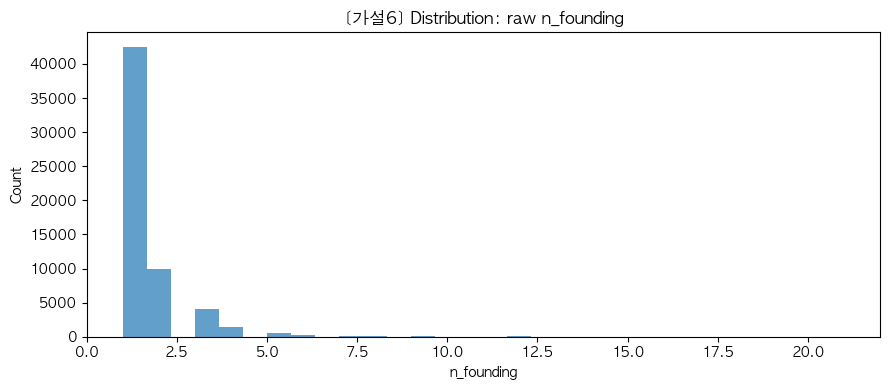

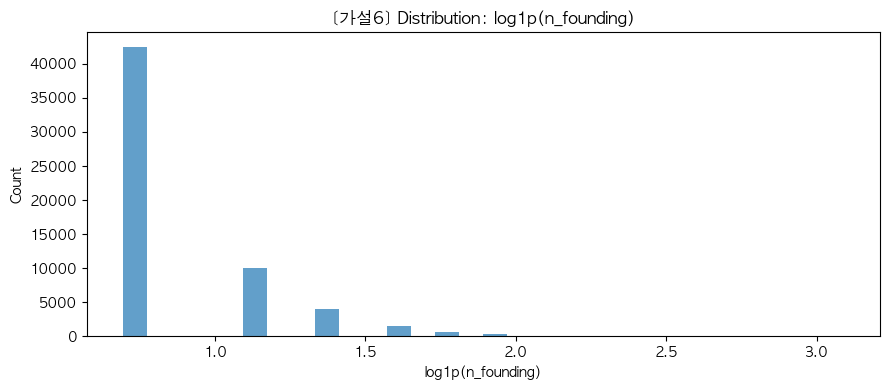


[가설6] Logistic 비교 (raw vs log1p)
RAW      : beta=0.0686, p=3.434e-11, OR=1.0710
LOG1P    : beta=0.3213, p=6.846e-15, OR=1.3789

[모델 적합도]
RAW  - AIC: 40515.24101995056 BIC: 40533.21877895663 McFadden R2: 0.0009858302652134832
LOG  - AIC: 40497.346282396386 BIC: 40515.324041402455 McFadden R2: 0.0014271175704210215

🧾 [해석: log1p 변환 로지스틱]
- p=6.846e-15 < 0.05 → log1p(n_founding)가 성공과 [유의하게 연관]이 있습니다.
- OR=1.379 (log1p 1단위 증가당 성공 odds가 1.379배로 증가)

📌 [비즈니스 해석]
- 창업 경험이 늘어날수록(특히 초반 구간의 증가) 성공 가능성이 올라가는 패턴일 수 있습니다.
- log 변환은 '경험 0→1의 증가' 같은 초기 변화의 영향이 더 크게 반영되고, 극단적으로 경험이 큰 소수(긴 꼬리)의 영향을 완화합니다.
- VC 관점에서는 'serial founder 유무/초기 경험의 존재'를 리스크 완화 신호로 활용하는 해석이 자연스럽습니다.

🚀 [후속 방향성]
1) raw vs log1p 중 AIC/BIC가 더 좋은 모델을 채택(일반적으로 더 낮은 쪽)
2) 통제변수 추가: size_bin, total_invested, diff_tot_cur_rel 등을 넣어도 log1p 효과가 유지되는지 확인(독립효과)
3) 비선형 확인: log1p 대신 스플라인/구간화(0,1,2~3,4+)로도 민감도 분석


In [30]:
# log(1+n_founding) 변환 후 로지스틱 재검증
alpha = 0.05
target = "success_flag"
x_raw = "n_founding"

# -------------------------
# 0) 데이터 준비
# -------------------------
tmp_founding = df[[x_raw, target]].copy()
tmp_founding[x_raw] = pd.to_numeric(tmp_founding[x_raw], errors="coerce")
tmp_founding[target] = pd.to_numeric(tmp_founding[target], errors="coerce")
tmp_founding = tmp_founding.dropna(subset=[x_raw, target]).copy()
tmp_founding = tmp_founding[tmp_founding[x_raw] >= 0].copy()
tmp_founding[target] = tmp_founding[target].astype(int)

# log(1+x) 변환 컬럼
tmp_founding["log1p_n_founding"] = np.log1p(tmp_founding[x_raw])

print("n:", len(tmp_founding))
print(tmp_founding[[x_raw, "log1p_n_founding"]].describe())

# -------------------------
# 1) 시각화: 변환 전/후 분포 비교
# -------------------------
plt.figure(figsize=(9,4))
plt.hist(tmp_founding[x_raw], bins=30, alpha=0.7, label="n_founding (raw)")
plt.xlabel("n_founding")
plt.ylabel("Count")
plt.title("[가설6] Distribution: raw n_founding")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
plt.hist(tmp_founding["log1p_n_founding"], bins=30, alpha=0.7, label="log1p(n_founding)")
plt.xlabel("log1p(n_founding)")
plt.ylabel("Count")
plt.title("[가설6] Distribution: log1p(n_founding)")
plt.tight_layout()
plt.show()

# -------------------------
# 2) 로지스틱 비교: raw vs log1p
#    H0: beta = 0 (성공과 무관)
#    H1: beta != 0
# -------------------------
def fit_logit(x_col):
    X = sm.add_constant(tmp_founding[[x_col]])
    y = tmp_founding[target]
    m = sm.Logit(y, X).fit(disp=0)
    beta = float(m.params[x_col])
    pval = float(m.pvalues[x_col])
    or_  = float(np.exp(beta))
    return m, beta, pval, or_

m_raw,  beta_raw,  p_raw,  or_raw  = fit_logit(x_raw)
m_log,  beta_log,  p_log,  or_log  = fit_logit("log1p_n_founding")

print("\n=========================")
print("[가설6] Logistic 비교 (raw vs log1p)")
print(f"RAW      : beta={beta_raw:.4f}, p={p_raw:.4g}, OR={or_raw:.4f}")
print(f"LOG1P    : beta={beta_log:.4f}, p={p_log:.4g}, OR={or_log:.4f}")
print("=========================\n")

# -------------------------
# 3) (선택) 모델 적합도 비교: AIC / BIC / pseudo R2(맥패든)
#    - 값이 낮을수록(AIC/BIC) 더 좋은 적합(동일 데이터 기준)
# -------------------------
def mcfadden_r2(model):
    # full model llf vs null model llnull
    return 1 - (model.llf / model.llnull)

print("[모델 적합도]")
print("RAW  - AIC:", m_raw.aic, "BIC:", m_raw.bic, "McFadden R2:", mcfadden_r2(m_raw))
print("LOG  - AIC:", m_log.aic, "BIC:", m_log.bic, "McFadden R2:", mcfadden_r2(m_log))

# -------------------------
# 4) 조건문 기반 해석 + 이후 방향성
# -------------------------
print("\n🧾 [해석: log1p 변환 로지스틱]")
if p_log < alpha:
    direction = "증가" if or_log > 1 else "감소"
    print(f"- p={p_log:.4g} < {alpha} → log1p(n_founding)가 성공과 [유의하게 연관]이 있습니다.")
    print(f"- OR={or_log:.3f} (log1p 1단위 증가당 성공 odds가 {or_log:.3f}배로 {direction})")

    # 비즈니스 해석(직관)
    print("\n📌 [비즈니스 해석]")
    print("- 창업 경험이 늘어날수록(특히 초반 구간의 증가) 성공 가능성이 올라가는 패턴일 수 있습니다.")
    print("- log 변환은 '경험 0→1의 증가' 같은 초기 변화의 영향이 더 크게 반영되고, 극단적으로 경험이 큰 소수(긴 꼬리)의 영향을 완화합니다.")
    print("- VC 관점에서는 'serial founder 유무/초기 경험의 존재'를 리스크 완화 신호로 활용하는 해석이 자연스럽습니다.")

    print("\n🚀 [후속 방향성]")
    print("1) raw vs log1p 중 AIC/BIC가 더 좋은 모델을 채택(일반적으로 더 낮은 쪽)")
    print("2) 통제변수 추가: size_bin, total_invested, diff_tot_cur_rel 등을 넣어도 log1p 효과가 유지되는지 확인(독립효과)")
    print("3) 비선형 확인: log1p 대신 스플라인/구간화(0,1,2~3,4+)로도 민감도 분석")
else:
    print(f"- p={p_log:.4g} ≥ {alpha} → log1p(n_founding)의 유의성을 확인하지 못했습니다(H0 기각 불가).")

    print("\n📌 [비즈니스 해석]")
    print("- 경험 자체가 단독으로 성공을 설명하는 신호가 약하거나,")
    print("- 경험 효과가 '특정 산업/단계'에서만 나타날 수 있습니다(예: 딥테크 vs B2C).")

    print("\n🚀 [후속 방향성]")
    print("1) serial founder(>=2) 같은 이진/구간 지표로 재검정")
    print("2) 산업/카테고리 층화 분석(IT/Bio/Fin 등) 또는 상호작용항(log1p×category)")
    print("3) 성공 정의(success_flag)가 IPO/M&A 중심인지 확인 후, 성공 유형별로 분리해 재검정")


### 가설 7) 마일스톤 수에 따라 성공률 차이

- H0(귀무가설): 성공/실패 그룹 간 n_milestone 차이가 없다. (또는 성공 odds와 무관)

- H1(대립가설): 차이가 있다. (일반적으로 성공 그룹이 더 많을 것으로 기대)

- 어떤 검정을 쓰는가 / 이유

      - n_milestone = 연속형(카운트), success_flag = 이진
      - → 두 그룹 비교(t/Welch 또는 Mann–Whitney) + 로지스틱 회귀(OR) 가 가장 실무적으로 해석이 좋음

      - 카운트는 보통 0이 많고 긴 꼬리 → 로지스틱에서 log1p 변환도 함께 추천

분석 표본: 4712 | fail: 3593 | success: 1119
count   4712.000
mean       2.541
std        3.445
min        1.000
25%        1.000
50%        1.000
75%        3.000
max       64.000
Name: n_milestone, dtype: float64


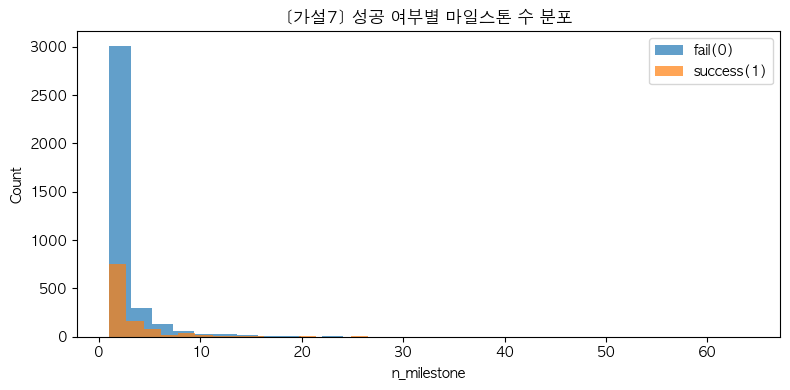

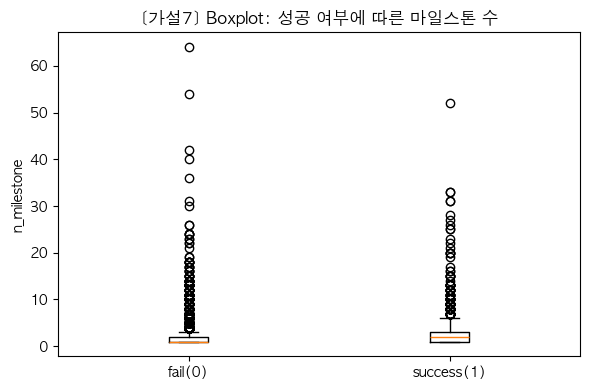

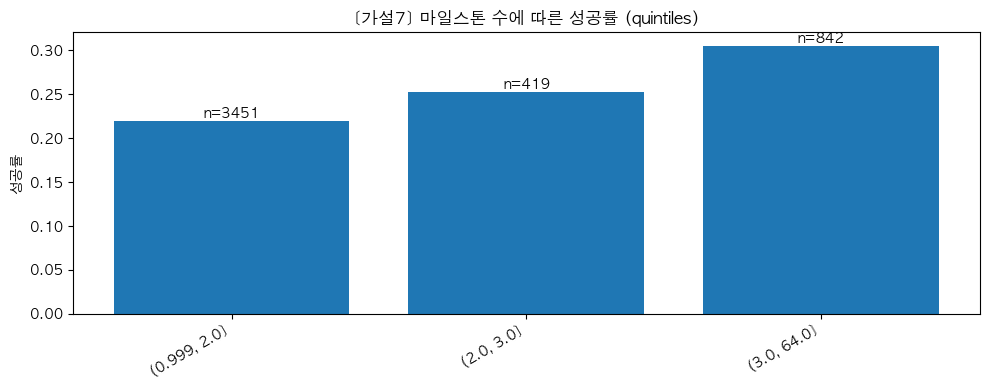

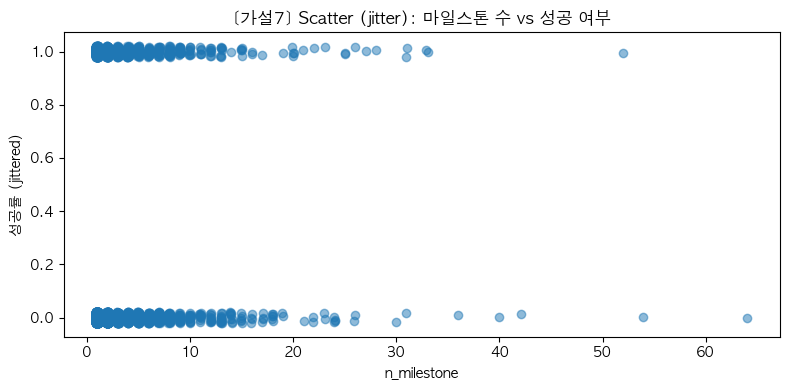


[정규성 체크]
fail: {'n': 3593, 'test': 'Shapiro', 'p': np.float64(1.5072052893047768e-74), 'normal': np.False_}
success: {'n': 1119, 'test': 'Shapiro', 'p': np.float64(1.4663418803350429e-47), 'normal': np.False_}

[등분산 체크]
{'test': 'Levene(median)', 'p': np.float64(2.8606283779842885e-08), 'equal_var': np.False_}

[가설7] 사용한 검정: Mann–Whitney U (비모수)
p-value: 7.945356319624192e-09
Effect size: {'cliffs_delta(success-fail)': np.float64(0.10418107694760466)}

[가설7] Logistic (raw vs log1p)
RAW   : beta=0.0495, p=8.527e-08, OR=1.0508, AIC=5140.57
LOG1P : beta=0.3914, p=9.02e-11, OR=1.4790, AIC=5129.14

🧾 [가설 7 결과 해석]
- p=7.945e-09 < 0.05 → [마일스톤 수와 성공률은 통계적으로 유의한 차이/연관]이 있습니다.
- 효과크기: {'cliffs_delta(success-fail)': np.float64(0.10418107694760466)}
- log1p 로지스틱 기준: 마일스톤 활동이 늘어날수록 성공 odds가 1.479배로 증가(p=9.02e-11).
  (log 변환은 극단적으로 큰 소수 기업의 영향을 줄여 모델을 더 안정적으로 만듭니다.)

📌 [비즈니스 해석]
- 마일스톤이 많다는 것은 제품 출시/파트너십/채용/확장 등 '외부에 관측 가능한 실행 이벤트'가 활발하다는 신호일 수 있습니다.
- VC 관점에서는 초기 심사에서 '실행 모멘텀(traction proxy)'로 활용

In [31]:
# successed_founder_company <-> mil을 merge
df_mile = df.merge(
    mil,
    how='left',
    left_on = 'rel_cf_id',
    right_on = 'mile_cfpr_id'
)
df_mile

# mile_cfpr_id 기준으로 집계
n_mil_success = df_mile.groupby('mile_cfpr_id').agg(
    success_flag = ('success_flag', 'first'),    # 성공 여부
    n_milestone = ('description', 'nunique')     # 마일스톤 수
).reset_index()
n_mil_success

# ============================================================
alpha = 0.05
target = "success_flag"
n = "n_milestone"

# -------------------------
# 0) 데이터 준비
# -------------------------
tmp_mile = n_mil_success[[n, target]].copy()
tmp_mile[n] = pd.to_numeric(tmp_mile[n], errors="coerce").fillna(0)
tmp_mile[target] = pd.to_numeric(tmp_mile[target], errors="coerce")
tmp_mile = tmp_mile.dropna(subset=[target]).copy()
tmp_mile[target] = tmp_mile[target].astype(int)

# 음수 방지(혹시 이상치)
tmp_mile = tmp_mile[tmp_mile[n] >= 0].copy()

g0_mile = tmp_mile[tmp_mile[target]==0][n]  # 실패
g1_mile = tmp_mile[tmp_mile[target]==1][n]  # 성공

print("분석 표본:", len(tmp_mile), "| fail:", len(g0_mile), "| success:", len(g1_mile))
print(tmp_mile[n].describe())

# =========================
# 1) 시각화 1: 분포(히스토그램)
# =========================
plt.figure(figsize=(8,4))
plt.hist(g0_mile, bins=30, alpha=0.7, label="fail(0)")
plt.hist(g1_mile, bins=30, alpha=0.7, label="success(1)")
plt.xlabel(n)
plt.ylabel("Count")
plt.title("[가설7] 성공 여부별 마일스톤 수 분포")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 2) 시각화 2: 박스플롯
# =========================
plt.figure(figsize=(6,4))
plt.boxplot([g0_mile.values, g1_mile.values], labels=["fail(0)", "success(1)"])
plt.ylabel(n)
plt.title("[가설7] Boxplot: 성공 여부에 따른 마일스톤 수")
plt.tight_layout()
plt.show()

# =========================
# 3) 시각화 3: 마일스톤 수 구간별 성공률(분위수 bin)
# =========================
tmp_mile["mil_bin"] = pd.qcut(tmp_mile[n], q=5, duplicates="drop")
rate_df = (
    tmp_mile.groupby("mil_bin")[target]
       .agg(success_rate="mean", n="count")
       .reset_index()
)

plt.figure(figsize=(10,4))
plt.bar(rate_df["mil_bin"].astype(str), rate_df["success_rate"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("성공률")
plt.title("[가설7] 마일스톤 수에 따른 성공률 (quintiles)")
for i, row in rate_df.iterrows():
    plt.text(i, row["success_rate"], f"n={int(row['n'])}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# =========================
# 4) (선택) 산점도: n_milestone vs success (지터)
# =========================
plt.figure(figsize=(8,4))
plt.scatter(tmp_mile[n] + np.random.uniform(-0.1,0.1,size=len(tmp_mile)), tmp_mile[target] + np.random.uniform(-0.02,0.02,size=len(tmp_mile)), alpha=0.5)
plt.xlabel(n)
plt.ylabel("성공률 (jittered)")
plt.title("[가설7] Scatter (jitter): 마일스톤 수 vs 성공 여부")
plt.tight_layout()
plt.show()

# =========================
# 5) 정규성/등분산 체크 (필요 시)
# =========================
def check_normality(v, alpha=0.05):
    v = pd.Series(v).dropna().astype(float)
    n = len(v)
    if n < 8:
        return {"n": n, "test": None, "p": np.nan, "normal": None}
    if n <= 5000:
        stat, p = stats.shapiro(v)
        return {"n": n, "test": "Shapiro", "p": p, "normal": (p >= alpha)}
    stat, p = stats.normaltest(v)
    return {"n": n, "test": "Normaltest(K2)", "p": p, "normal": (p >= alpha)}

def check_equal_var(a, b, alpha=0.05):
    a = pd.Series(a).dropna().astype(float)
    b = pd.Series(b).dropna().astype(float)
    stat, p = stats.levene(a, b, center="median")
    return {"test": "Levene(median)", "p": p, "equal_var": (p >= alpha)}

norm0 = check_normality(g0_mile, alpha=alpha)
norm1 = check_normality(g1_mile, alpha=alpha)
ev = check_equal_var(g0_mile, g1_mile, alpha=alpha)

print("\n[정규성 체크]")
print("fail:", norm0)
print("success:", norm1)
print("\n[등분산 체크]")
print(ev)

# =========================
# 6) 두 그룹 비교 검정: t/Welch vs Mann–Whitney 자동 선택
# =========================
def cohens_d(a, b):
    a = pd.Series(a).dropna().astype(float)
    b = pd.Series(b).dropna().astype(float)
    n1, n2 = len(a), len(b)
    s1, s2 = a.std(ddof=1), b.std(ddof=1)
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    return (a.mean() - b.mean()) / sp

def cliffs_delta(a, b):
    a = pd.Series(a).dropna().astype(float).values
    b = pd.Series(b).dropna().astype(float).values
    m, n = len(a), len(b)
    gt = sum(ai > bj for ai in a for bj in b)
    lt = sum(ai < bj for ai in a for bj in b)
    return (gt - lt) / (m*n)

if (norm0["normal"] is True) and (norm1["normal"] is True):
    if ev["equal_var"] is True:
        stat, p = stats.ttest_ind(g1_mile, g0_mile, equal_var=True, nan_policy="omit")
        test_used = "Student t-test (모수)"
    else:
        stat, p = stats.ttest_ind(g1_mile, g0_mile, equal_var=False, nan_policy="omit")
        test_used = "Welch t-test (모수, 등분산X)"
else:
    stat, p = mannwhitneyu(g1_mile, g0_mile, alternative="two-sided")
    test_used = "Mann–Whitney U (비모수)"

print(f"\n[가설7] 사용한 검정: {test_used}")
print("p-value:", p)

effect = None
if p < alpha:  # 유의할 때만 효과크기
    if "t-test" in test_used:
        effect = {"cohens_d(success-fail)": cohens_d(g1_mile, g0_mile)}
    else:
        effect = {"cliffs_delta(success-fail)": cliffs_delta(g1_mile, g0_mile)}
print("Effect size:", effect)

# =========================
# 7) (권장) 로지스틱: raw & log1p 비교(카운트의 긴 꼬리 대응)
# =========================
tmp_mile["log1p_n_milestone"] = np.log1p(tmp_mile[n])

def fit_logit(xcol):
    X = sm.add_constant(tmp_mile[[xcol]])
    y = tmp_mile[target]
    m = sm.Logit(y, X).fit(disp=0)
    beta = float(m.params[xcol])
    pval = float(m.pvalues[xcol])
    or_  = float(np.exp(beta))
    return m, beta, pval, or_

m_raw, beta_raw, p_raw, or_raw = fit_logit(n)
m_log, beta_log, p_log, or_log = fit_logit("log1p_n_milestone")

print("\n[가설7] Logistic (raw vs log1p)")
print(f"RAW   : beta={beta_raw:.4f}, p={p_raw:.4g}, OR={or_raw:.4f}, AIC={m_raw.aic:.2f}")
print(f"LOG1P : beta={beta_log:.4f}, p={p_log:.4g}, OR={or_log:.4f}, AIC={m_log.aic:.2f}")

# =========================
# 8) 조건문 기반 해석 + 이후 방향성
# =========================
print("\n🧾 [가설 7 결과 해석]")
if p < alpha:
    print(f"- p={p:.4g} < {alpha} → [마일스톤 수와 성공률은 통계적으로 유의한 차이/연관]이 있습니다.")
    if effect is not None:
        print(f"- 효과크기: {effect}")

    # 로지스틱(log1p) 기준을 우선 메시지로 사용(카운트 안정성)
    if p_log < alpha:
        direction = "증가" if or_log > 1 else "감소"
        print(f"- log1p 로지스틱 기준: 마일스톤 활동이 늘어날수록 성공 odds가 {or_log:.3f}배로 {direction}(p={p_log:.4g}).")
        print("  (log 변환은 극단적으로 큰 소수 기업의 영향을 줄여 모델을 더 안정적으로 만듭니다.)")

    print("\n📌 [비즈니스 해석]")
    print("- 마일스톤이 많다는 것은 제품 출시/파트너십/채용/확장 등 '외부에 관측 가능한 실행 이벤트'가 활발하다는 신호일 수 있습니다.")
    print("- VC 관점에서는 초기 심사에서 '실행 모멘텀(traction proxy)'로 활용 가능하며, 후속 투자 여부 판단에도 보조지표가 될 수 있습니다.")

    print("\n🚀 [후속 방향성]")
    print("1) 마일스톤 수가 '성과'의 결과일 수도 있음(역인과) → time_to_last_round / round_tempo_months 같은 시간 변수로 통제한 다변량 로지스틱 권장")
    print("2) 산업별로 마일스톤 패턴이 다름 → 카테고리 층화 분석 또는 (milestone×category) 상호작용 확인")
    print("3) 마일스톤을 '기간당 개수(tempo)'로 바꾸면 더 강한 신호일 수 있음 → 마일스톤 밀도(개수/운영기간) 지표도 추가")
else:
    print(f"- p={p:.4g} ≥ {alpha} → [마일스톤 수가 성공률과 유의한 연관이 있다고 보기 어렵습니다](H0 기각 불가).")
    print("\n📌 [비즈니스 해석]")
    print("- 마일스톤 '개수' 자체는 성공을 가르는 핵심 신호가 아닐 수 있습니다.")
    print("- 마일스톤의 '질/유형' 또는 '투자 타이밍'이 더 중요할 가능성이 있습니다.")

    print("\n🚀 [후속 방향성]")
    print("1) 개수 대신 '핵심 마일스톤(예: 출시/파트너십/매출/규모확장)' 보유 여부 또는 특정 이벤트 발생 여부로 재정의")
    print("2) 마일스톤 수를 log1p로 변환한 로지스틱(p_log) 결과도 참고하여 안정성 비교")
    print("3) 표본/결측 영향 점검: 마일스톤 데이터가 기록되지 않은 기업이 많은지 확인(coverage bias)")


### 가설 8) 관계 수 변화가 적을수록 성공↑

   - 검정: diff_tot_cur_rel(연속) vs success(이진) → 자동(t/Welch/MWU)
   - 이유: 두 그룹의 변화량 분포/평균 차이

        - H0: 관계 변화량은 성공과 무관
        - H1: 관련 있음

        - 효과크기: (유의 시) Cohen’s d 또는 Cliff’s delta

In [32]:
x = "diff_tot_cur_rel"  
if x in df.columns:
    H8_result = test_continuous_vs_binary(df, x=x, do_checks=True)
    print(H8_result["test"], H8_result["p"], H8_result["effect"])
else:
    print("⚠️ df에 diff_tot_cur_rel가 없어요. 관계 변화량 컬럼명을 확인해줘.")

⚠️ df에 diff_tot_cur_rel가 없어요. 관계 변화량 컬럼명을 확인해줘.


### 가설 9) 회사 규모가 클수록 성공↑

   - 검정: size_bin(범주/서열) vs success(이진) → 카이제곱
   - 이유: 규모 카테고리별 성공 비율 차이

        - H0: 규모와 성공은 독립 (규모별 성공률 차이 없음)
        - H1: 독립 아님       (일반적으로 규모가 클수록 성공률 상승 기대)
        - 효과크기: (유의 시) Cramer’s V
        - (선택) size_bin이 서열형이면 로지스틱으로 OR 해석 가능

In [33]:
df['company_size'].value_counts()

company_size
대형팀    29710
소형팀    15799
중형팀    13703
Name: count, dtype: int64

분석 표본: 59212
company_size
대형팀    29710
소형팀    15799
중형팀    13703
Name: count, dtype: int64
success_flag
0    52814
1     6398
Name: count, dtype: int64


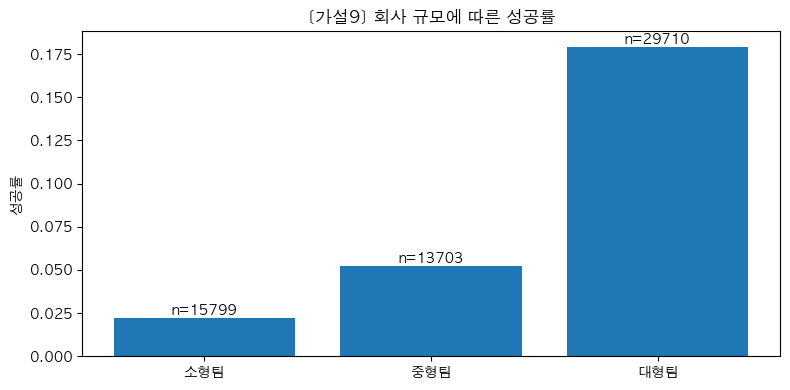

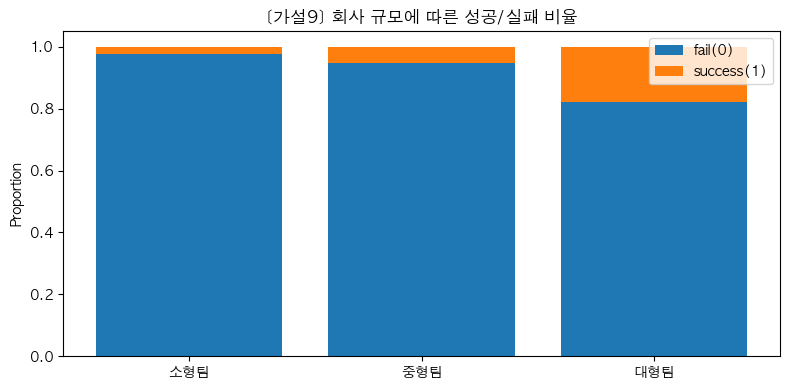


[가설9] Chi-square independence test
table:
 success_flag      0     1
company_size             
소형팀           15445   354
중형팀           12983   720
대형팀           24386  5324
chi2: 3200.9544817135206 | dof: 2 | p-value: 0.0
Effect size (Cramer's V): 0.2325063850868462

[유의] 성공(1) 기준 표준화 잔차(+) : 성공이 기대보다 많은 규모
company_size
대형팀    37.307
중형팀   -19.768
소형팀   -32.749
Name: 1, dtype: float64

[유의] 성공(1) 기준 표준화 잔차(-) : 성공이 기대보다 적은 규모
company_size
소형팀   -32.749
중형팀   -19.768
대형팀    37.307
Name: 1, dtype: float64

[가설9] Logistic regression (ordinal company_size)
coef p-value: 0.0
Odds Ratio (per +1 size step): 3.343200532489375

🧾 [가설 9 결과 해석]
- p=0 < 0.05 → [회사 규모와 성공률은 유의하게 연관]이 있습니다.
- Cramer's V=0.233 → 효과크기는 중간 이하(투자 판단에서 보조 신호로 유용)
- 서열 로지스틱: 규모가 1단계(소→중, 중→대) 커질 때 성공 odds가 3.343배로 증가(p=0).

📌 [비즈니스 해석]
- 규모가 큰 팀은 제품개발/세일즈/운영 등 리소스가 확보되어 실행력이 높을 가능성이 있어 성공률이 높게 나타날 수 있습니다.
- 다만 규모는 '원인'이라기보다 성장 결과일 수 있어(역인과) 투자금/라운드수/운영기간과 얽힐 수 있습니다.

🚀 [후속 방향성 제안]
1) 통제변수 포함 다변량 로지스틱: total_invested, rou

In [34]:
alpha = 0.05
size_col = "company_size"     
target = "success_flag"

# -------------------------
# 0) 데이터 준비
# -------------------------
tmp_size = df[[size_col, target]].copy()
tmp_size[size_col] = tmp_size[size_col].replace(["nan", "None", "NULL", ""], np.nan)
tmp_size[target] = pd.to_numeric(tmp_size[target], errors="coerce")
tmp_size = tmp_size.dropna(subset=[size_col, target]).copy()
tmp_size[target] = tmp_size[target].astype(int)

# ✅ 서열(작→큰) 순서를 명시적으로 고정 (중요!)
order = ["소형팀", "중형팀", "대형팀"]
tmp_size[size_col] = pd.Categorical(tmp_size[size_col], categories=order, ordered=True)

print("분석 표본:", len(tmp_size))
print(tmp_size[size_col].value_counts(dropna=False))
print(tmp_size[target].value_counts())

# =========================
# 1) 시각화 1: 규모별 성공률 막대 + 표본수(n)
# =========================
size_rate_df = (
    tmp_size.groupby(size_col)[target]
       .agg(success_rate="mean", n="count")
       .reset_index()
)

plt.figure(figsize=(8,4))
plt.bar(size_rate_df[size_col].astype(str), size_rate_df["success_rate"])
plt.ylabel("성공률")
plt.title("[가설9] 회사 규모에 따른 성공률")
for i, row in size_rate_df.iterrows():
    plt.text(i, row["success_rate"], f"n={int(row['n'])}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# =========================
# 2) 시각화 2: 규모별 성공/실패 비율(스택드 바 느낌)
#    - 성공률만 보면 '실패율'이 가려져서 보조로 보기 좋음
# =========================
ct_ratio = pd.crosstab(tmp_size[size_col], tmp_size[target], normalize="index")
ct_count = pd.crosstab(tmp_size[size_col], tmp_size[target])

plt.figure(figsize=(8,4))
plt.bar(ct_ratio.index.astype(str), ct_ratio.get(0, 0), label="fail(0)")
plt.bar(ct_ratio.index.astype(str), ct_ratio.get(1, 0), bottom=ct_ratio.get(0, 0), label="success(1)")
plt.ylabel("Proportion")
plt.title("[가설9] 회사 규모에 따른 성공/실패 비율")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 3) 통계검정: 카이제곱(독립성)
#  - 이유: company_size(범주형) vs success_flag(범주형)
# -------------------------
# H0: company_size와 success_flag는 독립(규모별 성공률 차이 없음)
# H1: 독립이 아님(규모별 성공률 차이 있음)
# =========================
ct_size = pd.crosstab(tmp_size[size_col], tmp_size[target])
chi2, p, dof, expected = chi2_contingency(ct_size)

# 효과크기: Cramer's V
n_total = ct_size.to_numpy().sum()
r, k = ct_size.shape
cramers_v = np.sqrt((chi2 / n_total) / (min(r-1, k-1)))

print("\n=========================")
print("[가설9] Chi-square independence test")
print("table:\n", ct_size)
print("chi2:", chi2, "| dof:", dof, "| p-value:", p)
print("Effect size (Cramer's V):", cramers_v)
print("=========================\n")

# =========================
# 4) (유의 시) 표준화 잔차: 어떤 규모가 차이를 주도?
#  - |z| > 2 이면 기대 대비 관측이 많이 다름
# =========================
if p < alpha:
    obs = ct_size.values
    std_resid = (obs - expected) / np.sqrt(expected)
    resid_df = pd.DataFrame(std_resid, index=ct_size.index, columns=ct_size.columns)

    if 1 in resid_df.columns:
        print("[유의] 성공(1) 기준 표준화 잔차(+) : 성공이 기대보다 많은 규모")
        print(resid_df[1].sort_values(ascending=False))
        print("\n[유의] 성공(1) 기준 표준화 잔차(-) : 성공이 기대보다 적은 규모")
        print(resid_df[1].sort_values(ascending=True))

# =========================
# 5) (권장) 서열 로지스틱: 규모 1단계 증가할 때 성공 odds 변화(OR)
#  - company_size가 서열형(소<중<대)이므로 해석이 매우 직관적
# =========================
tmp_size["_size_rank"] = tmp_size[size_col].cat.codes  # 소=0, 중=1, 대=2

X = sm.add_constant(tmp_size[["_size_rank"]])
y = tmp_size[target].astype(int)

m = sm.Logit(y, X).fit(disp=0)
or_value = float(np.exp(m.params["_size_rank"]))
p_logit  = float(m.pvalues["_size_rank"])

print("\n[가설9] Logistic regression (ordinal company_size)")
print("coef p-value:", p_logit)
print("Odds Ratio (per +1 size step):", or_value)

# =========================
# 6) 조건문 기반 해석 + 이후 방향성
# =========================
print("\n🧾 [가설 9 결과 해석]")
if p < alpha:
    if cramers_v < 0.1:
        eff_txt = "효과크기는 작음(유의하지만 단독 신호로는 약할 수 있음)"
    elif cramers_v < 0.3:
        eff_txt = "효과크기는 중간 이하(투자 판단에서 보조 신호로 유용)"
    else:
        eff_txt = "효과크기는 중간 이상(규모가 성공과 꽤 강하게 연결될 가능성)"

    print(f"- p={p:.4g} < {alpha} → [회사 규모와 성공률은 유의하게 연관]이 있습니다.")
    print(f"- Cramer's V={cramers_v:.3f} → {eff_txt}")

    if p_logit < alpha:
        direction = "증가" if or_value > 1 else "감소"
        print(f"- 서열 로지스틱: 규모가 1단계(소→중, 중→대) 커질 때 성공 odds가 {or_value:.3f}배로 {direction}(p={p_logit:.4g}).")

    print("\n📌 [비즈니스 해석]")
    print("- 규모가 큰 팀은 제품개발/세일즈/운영 등 리소스가 확보되어 실행력이 높을 가능성이 있어 성공률이 높게 나타날 수 있습니다.")
    print("- 다만 규모는 '원인'이라기보다 성장 결과일 수 있어(역인과) 투자금/라운드수/운영기간과 얽힐 수 있습니다.")

    print("\n🚀 [후속 방향성 제안]")
    print("1) 통제변수 포함 다변량 로지스틱: total_invested, round_tempo_months, time_to_last_round를 넣어도 규모 효과가 유지되는지 확인")
    print("2) 표준화 잔차에서 성공을 주도하는 규모 구간(예: 대형팀) 중심으로 스토리 구성(‘어느 구간부터 유의미하게 달라지는가’)") 
    print("3) 산업별(회사 카테고리)로 규모의 의미가 다를 수 있음 → company_size×category 상호작용 검토")
else:
    print(f"- p={p:.4g} ≥ {alpha} → [회사 규모와 성공률의 유의한 연관을 확인하지 못했습니다](H0 기각 불가).")
    print(f"- Cramer's V={cramers_v:.3f} → (유의하지 않으므로 해석은 보수적으로)")

    print("\n📌 [비즈니스 해석]")
    print("- team size 자체가 성공을 가르는 핵심 신호가 아닐 수 있고, 다른 요인(산업/투자금/조직안정성)이 더 강할 수 있습니다.")

    print("\n🚀 [후속 방향성 제안]")
    print("1) 규모 정의/측정의 정확도(업데이트 시점, 결측 처리) 점검")
    print("2) 규모 대신 성장/활동지표(마일스톤 수, 투자 템포 등)와 함께 모델링해 상대 중요도 비교")

### 가설 10) 직원(직무) 구성이 다양할수록 성공↑

   - 검정: 다양성 지표(연속) vs success(이진) → 자동(t/Welch/MWU)
   - 이유: 성공/실패 간 다양성 분포 차이

        - H0: 직무 다양성(n_title)은 성공(success_flag)과 무관 -> 성공/실패 그룹 간 차이 없음
        - H1: 관련 있음                                    -> 성공 그룹이 더 큰 n_title을 가질 가능성

        - 효과크기: (유의 시) Cohen’s d / Cliff’s delta

In [35]:
# rel 직원 구성 다양성
rel['cat_rel_title'].value_counts()

# 회사별 직무 구성 수
title_diversity = rel.groupby('rel_cf_id')['cat_rel_title'].nunique().reset_index(name='n_title')
title_diversity

# df에 직무구성 수 결합
df_diversity = df.merge(
    title_diversity,
    how = 'left',
    on  = 'rel_cf_id'
)
df_diversity

,rel_p_id,founder_ever_success,rel_cf_id,n_founding,is_past,sequence,birthplace,degree_level,subject,institution,graduated_at,objects_cfpr_id,success_flag,relationships,category,company_size,n_title
0,p:10,1,c:5,1,0,1,NaN,NaN,Computer Science / Software,harvard university,NaN,c:5,1,269.000,social,대형팀,20
1,p:100009,0,c:152329,2,0,1,NaN,NaN,NaN,NaN,NaN,c:152329,0,2.000,software,중형팀,1
2,p:100009,0,c:81559,2,0,2,NaN,NaN,NaN,NaN,NaN,c:81559,0,2.000,consulting,중형팀,1
3,p:100017,0,c:81564,1,0,1,NaN,NaN,NaN,NaN,NaN,c:81564,0,15.000,medical,대형팀,6
4,p:100025,0,c:287,1,0,1,NaN,NaN,NaN,NaN,NaN,c:287,0,21.000,games_video,대형팀,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59207,p:99982,1,c:16993,2,1,1,NaN,NaN,NaN,NaN,NaN,c:16993,1,2.000,games_video,중형팀,2
59208,p:99982,1,c:81541,2,0,2,NaN,NaN,NaN,NaN,NaN,c:81541,0,3.000,software,대형팀,2
59209,p:99988,0,c:64683,1,0,1,NaN,2.000,Computer Science / Software,bristol university,2004-01-01,c:64683,0,1.000,software,소형팀,1
59210,p:99994,0,c:3643,1,0,1,NaN,2.000,Marketing / Communications,"madras, india university",NaN,c:3643,0,3.000,public_relations,대형팀,2


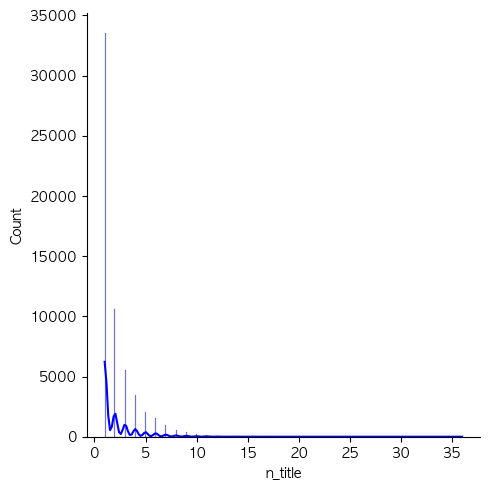

In [36]:
sns.displot(df_diversity['n_title'], kde=True, color='blue')
plt.show()

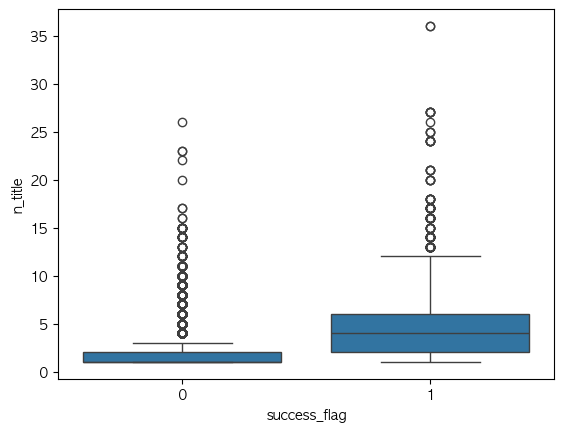

In [37]:
# 직무 구성 수 boxplot
sns.boxplot(data=df_diversity, x='success_flag', y='n_title')
plt.show()

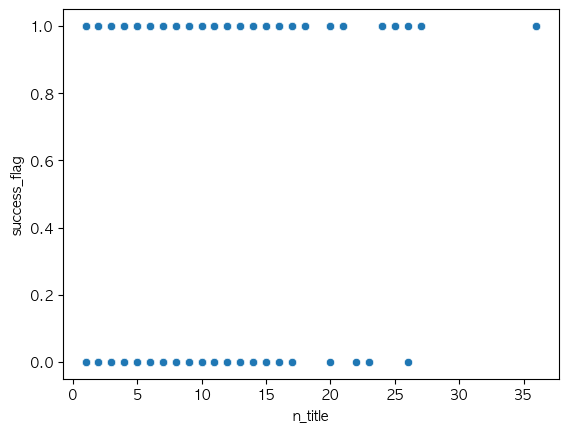

In [38]:
sns.scatterplot(data=df_diversity, x='n_title', y='success_flag')
plt.show()

In [39]:
diversity_result = test_continuous_vs_binary(df_diversity, x='n_title', do_checks=True)
print(diversity_result["test"], diversity_result["p"], diversity_result["effect"])

Mann–Whitney U 0.0 {'cliffs_delta': np.float64(0.5560110787925275)}


분석 표본: 59212 | fail: 52814 | success: 6398
count   59212.000
mean        2.145
std         1.981
min         1.000
25%         1.000
50%         1.000
75%         3.000
max        36.000
Name: n_title, dtype: float64
n_title 값 분포(상위 20):
 n_title
1     33532
2     10585
3      5540
4      3426
5      2044
6      1537
7       936
8       595
9       384
10      229
11      157
12       71
14       39
13       36
16       23
15       22
17       19
18        7
24        6
20        5
Name: count, dtype: int64


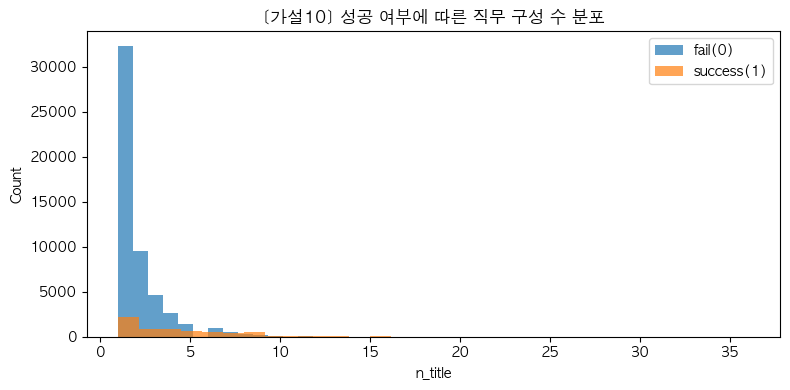

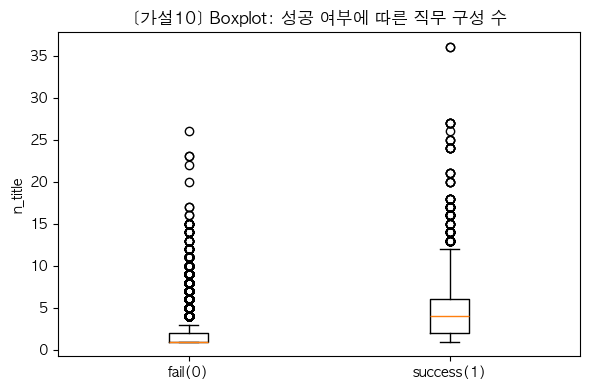

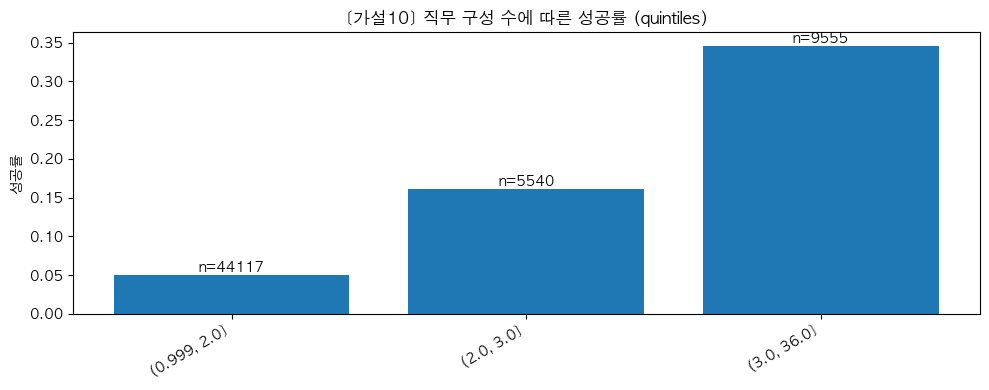


[정규성 체크]
fail: {'n': 52814, 'test': 'Normaltest(K2)', 'p': np.float64(0.0), 'normal': np.False_}
success: {'n': 6398, 'test': 'Normaltest(K2)', 'p': np.float64(0.0), 'normal': np.False_}

[등분산 체크]
{'test': 'Levene(median)', 'p': np.float64(0.0), 'equal_var': np.False_}

[가설10] 사용한 검정: Mann–Whitney U (비모수)
p-value: 0.0
Effect size: {'cliffs_delta(success-fail)': np.float64(0.5560110787925275)}

[가설10] Logistic (raw vs log1p)
RAW   : beta=0.4341, p=0, OR=1.5436, AIC=34440.82
LOG1P : beta=2.1373, p=0, OR=8.4761, AIC=33709.73

🧾 [가설 10 결과 해석]
- p=0 < 0.05 → [직무 다양성(n_title)과 성공률은 유의하게 연관]이 있습니다.
- 효과크기는 중간 이상
- log1p 로지스틱: 직무 다양성 증가 시 성공 odds가 8.476배로 증가(p=0).
  (log 변환은 극단적으로 큰 소수 기업의 영향을 줄여 모델을 더 안정적으로 만듭니다.)

📌 [비즈니스 해석]
- n_title이 높다는 것은 개발/사업/운영/마케팅 등 다양한 기능이 갖춰져 실행 리스크가 낮아졌다는 신호일 수 있습니다.
- VC 관점에서는 ‘팀 구성 완성도(Functional completeness)’의 근사치로 활용 가능해요.

🚀 [후속 방향성 제안]
1) company_size(규모)와 n_title이 강하게 연관될 수 있음 → company_size 통제한 다변량 로지스틱으로 ‘독립 효과’ 확인
2) 직무 카테고리 분류 정확도 점검: cat_rel_title이 

In [40]:
alpha = 0.05
n = "n_title"          # 직무 다양성(회사별 고유 직무 수)
target = "success_flag"

# -------------------------
# 0) 데이터 준비
# -------------------------
tmp_diversity = df_diversity[[n, target]].copy()

tmp_diversity[n] = pd.to_numeric(tmp_diversity[n], errors="coerce")
tmp_diversity[target] = pd.to_numeric(tmp_diversity[target], errors="coerce")

# 직무 정보 없는 회사는 0으로 둘지(=직무기록 없음), 제외할지 선택 가능
# 보통은 "기록 없음" 편향이 있을 수 있어 일단 제외를 추천
tmp_diversity = tmp_diversity.dropna(subset=[n, target]).copy()

tmp_diversity[target] = tmp_diversity[target].astype(int)

# 이상치/음수 방지
tmp_diversity = tmp_diversity[tmp_diversity[n] >= 0].copy()

g0_diversity = tmp_diversity[tmp_diversity[target] == 0][n]  # 실패
g1_diversity = tmp_diversity[tmp_diversity[target] == 1][n]  # 성공

print("분석 표본:", len(tmp_diversity), "| fail:", len(g0_diversity), "| success:", len(g1_diversity))
print(tmp_diversity[n].describe())
print("n_title 값 분포(상위 20):\n", tmp_diversity[n].value_counts().head(20))

# =========================
# 1) 시각화 1: 성공/실패별 n_title 분포(히스토그램)
# =========================
plt.figure(figsize=(8,4))
plt.hist(g0_diversity, bins=30, alpha=0.7, label="fail(0)")
plt.hist(g1_diversity, bins=30, alpha=0.7, label="success(1)")
plt.xlabel(n)
plt.ylabel("Count")
plt.title("[가설10] 성공 여부에 따른 직무 구성 수 분포")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 2) 시각화 2: 박스플롯
# =========================
plt.figure(figsize=(6,4))
plt.boxplot([g0_diversity.values, g1_diversity.values], labels=["fail(0)", "success(1)"])
plt.ylabel(n)
plt.title("[가설10] Boxplot: 성공 여부에 따른 직무 구성 수")
plt.tight_layout()
plt.show()

# =========================
# 3) 시각화 3: 직무 다양성 구간별 성공률 (분위수 bin)
#  - 카운트 분포가 치우쳐 있어도 비교가 되게 qcut 사용
# =========================
tmp_diversity["title_bin"] = pd.qcut(tmp_diversity[n], q=5, duplicates="drop")
diversity_rate_df = (
    tmp_diversity.groupby("title_bin")[target]
       .agg(success_rate="mean", n="count")
       .reset_index()
)

plt.figure(figsize=(10,4))
plt.bar(diversity_rate_df["title_bin"].astype(str), diversity_rate_df["success_rate"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("성공률")
plt.title("[가설10] 직무 구성 수에 따른 성공률 (quintiles)")
for i, row in diversity_rate_df.iterrows():
    plt.text(i, row["success_rate"], f"n={int(row['n'])}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# =========================
# 4) 정규성/등분산 체크
# =========================
def check_normality(v, alpha=0.05):
    v = pd.Series(v).dropna().astype(float)
    n = len(v)
    if n < 8:
        return {"n": n, "test": None, "p": np.nan, "normal": None}
    if n <= 5000:
        stat, p = stats.shapiro(v)
        return {"n": n, "test": "Shapiro", "p": p, "normal": (p >= alpha)}
    stat, p = stats.normaltest(v)
    return {"n": n, "test": "Normaltest(K2)", "p": p, "normal": (p >= alpha)}

def check_equal_var(a, b, alpha=0.05):
    a = pd.Series(a).dropna().astype(float)
    b = pd.Series(b).dropna().astype(float)
    stat, p = stats.levene(a, b, center="median")
    return {"test": "Levene(median)", "p": p, "equal_var": (p >= alpha)}

norm0 = check_normality(g0_diversity, alpha=alpha)
norm1 = check_normality(g1_diversity, alpha=alpha)
ev = check_equal_var(g0_diversity, g1_diversity, alpha=alpha)

print("\n[정규성 체크]")
print("fail:", norm0)
print("success:", norm1)
print("\n[등분산 체크]")
print(ev)

# =========================
# 5) 통계검정 선택 + 실행 (자동)
# -------------------------
# H0: 성공/실패 그룹 간 n_title 차이 없음
# H1: 차이 있음 (성공 그룹이 더 클 가능성)
# =========================
def cohens_d(a, b):
    a = pd.Series(a).dropna().astype(float)
    b = pd.Series(b).dropna().astype(float)
    n1, n2 = len(a), len(b)
    s1, s2 = a.std(ddof=1), b.std(ddof=1)
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    return (a.mean() - b.mean()) / sp

def cliffs_delta(a, b):
    a = pd.Series(a).dropna().astype(float).values
    b = pd.Series(b).dropna().astype(float).values
    m, n = len(a), len(b)
    gt = sum(ai > bj for ai in a for bj in b)
    lt = sum(ai < bj for ai in a for bj in b)
    return (gt - lt) / (m*n)

if (norm0["normal"] is True) and (norm1["normal"] is True):
    if ev["equal_var"] is True:
        stat, p = stats.ttest_ind(g1_diversity, g0_diversity, equal_var=True, nan_policy="omit")
        test_used = "Student t-test (모수)"
    else:
        stat, p = stats.ttest_ind(g1_diversity, g0_diversity, equal_var=False, nan_policy="omit")
        test_used = "Welch t-test (모수, 등분산X)"
else:
    stat, p = mannwhitneyu(g1_diversity, g0_diversity, alternative="two-sided")
    test_used = "Mann–Whitney U (비모수)"

print(f"\n[가설10] 사용한 검정: {test_used}")
print("p-value:", p)

# 유의할 때만 효과크기
effect = None
if p < alpha:
    if "t-test" in test_used:
        effect = {"cohens_d(success-fail)": cohens_d(g1_diversity, g0_diversity)}
    else:
        effect = {"cliffs_delta(success-fail)": cliffs_delta(g1_diversity, g0_diversity)}
print("Effect size:", effect)

# =========================
# 6) 로지스틱 회귀(OR): raw vs log1p 비교 (카운트 안정화)
# =========================
tmp_diversity["log1p_n_title"] = np.log1p(tmp_diversity[n])

def fit_logit(xcol):
    X = sm.add_constant(tmp_diversity[[xcol]])
    y = tmp_diversity[target].astype(int)
    m = sm.Logit(y, X).fit(disp=0)
    beta = float(m.params[xcol])
    pval = float(m.pvalues[xcol])
    or_  = float(np.exp(beta))
    return m, beta, pval, or_

m_raw, beta_raw, p_raw, or_raw = fit_logit(n)
m_log, beta_log, p_log, or_log = fit_logit("log1p_n_title")

print("\n[가설10] Logistic (raw vs log1p)")
print(f"RAW   : beta={beta_raw:.4f}, p={p_raw:.4g}, OR={or_raw:.4f}, AIC={m_raw.aic:.2f}")
print(f"LOG1P : beta={beta_log:.4f}, p={p_log:.4g}, OR={or_log:.4f}, AIC={m_log.aic:.2f}")

# =========================
# 7) 조건문 기반 해석 + 이후 방향성
# =========================
print("\n🧾 [가설 10 결과 해석]")
if p < alpha:
    eff_txt = ""
    if effect is not None:
        key = list(effect.keys())[0]
        val = list(effect.values())[0]
        if "cohens_d" in key:
            if abs(val) < 0.2: eff_txt = "효과크기는 작음(유의하지만 단독 신호는 약할 수 있음)"
            elif abs(val) < 0.5: eff_txt = "효과크기는 중간 이하(심사 보조 신호로 유용)"
            else: eff_txt = "효과크기는 중간 이상(의사결정 신호로 의미 가능)"
        else:
            if abs(val) < 0.147: eff_txt = "효과크기는 작음"
            elif abs(val) < 0.33: eff_txt = "효과크기는 중간 이하"
            else: eff_txt = "효과크기는 중간 이상"

    print(f"- p={p:.4g} < {alpha} → [직무 다양성(n_title)과 성공률은 유의하게 연관]이 있습니다.")
    if eff_txt:
        print(f"- {eff_txt}")

    # 로지스틱은 log1p를 (긴 꼬리 안정성)
    if p_log < alpha:
        direction = "증가" if or_log > 1 else "감소"
        print(f"- log1p 로지스틱: 직무 다양성 증가 시 성공 odds가 {or_log:.3f}배로 {direction}(p={p_log:.4g}).")
        print("  (log 변환은 극단적으로 큰 소수 기업의 영향을 줄여 모델을 더 안정적으로 만듭니다.)")

    print("\n📌 [비즈니스 해석]")
    print("- n_title이 높다는 것은 개발/사업/운영/마케팅 등 다양한 기능이 갖춰져 실행 리스크가 낮아졌다는 신호일 수 있습니다.")
    print("- VC 관점에서는 ‘팀 구성 완성도(Functional completeness)’의 근사치로 활용 가능해요.")

    print("\n🚀 [후속 방향성 제안]")
    print("1) company_size(규모)와 n_title이 강하게 연관될 수 있음 → company_size 통제한 다변량 로지스틱으로 ‘독립 효과’ 확인")
    print("2) 직무 카테고리 분류 정확도 점검: cat_rel_title이 너무 세분/거칠면 8~12개 대분류로 재분류해 n_title 재계산")
    print("3) n_title(양) 외에도 균형(엔트로피) 지표가 더 강할 수 있음 → role_entropy도 같이 만들어 비교(AIC/OR)")
else:
    print(f"- p={p:.4g} ≥ {alpha} → [직무 다양성(n_title)과 성공률의 유의한 연관을 확인하지 못했습니다](H0 기각 불가).")

    print("\n📌 [비즈니스 해석]")
    print("- 직무 다양성의 ‘개수’만으로는 성공을 설명하기 어려울 수 있고,")
    print("- 특정 핵심 직무(예: CTO/VP Sales)의 존재 여부가 더 중요할 가능성이 있습니다.")

    print("\n🚀 [후속 방향성 제안]")
    print("1) n_title을 구간화(예: 0~2 / 3~5 / 6+) 해서 비선형 효과 확인")
    print("2) 핵심 직무 플래그(CTO 존재, Sales Lead 존재 등)로 재정의해 재검정")
    print("3) 통제변수 포함 모델에서 상대 중요도 비교(투자금/투자템포/마일스톤 수/규모 등)")